In [3]:
# On importe les librairies dont on aura besoin pour ce tp
from math import sqrt
import warnings
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib

In [4]:
# Pour ne pas avoir les warnings lors de la compilation
warnings.filterwarnings("ignore")

# Lieu où se trouve le fichier
_DOSSIER = 'C:\\Users\\Toni\\Desktop\\pas_synchro\\p4\\'
_DOSSIERPKL = 'C:\\Users\\Toni\\python\\python\\Projet_4\\pkl'
_DOSSIERIMAGE = 'C:\\Users\\Toni\\python\\python\\Projet_4\\images'
_FICHIERDATA = _DOSSIER + 'dataset_p4.csv'
_VERBOSE = 10

# Booléean pour faire la différence entre un fit et un joblib load
_RECALCUL_JOBLIB = False
_RECALCUL_JOBLIB_HYP = False

# Fonction de calcul pour tous les algorithmes différents pour chaque compagnie


In [5]:
def lancer_algorithme(data):

    # Logging for Visual Comparison
    log_cols = ["Classifier", "Id", "RMSE", "R2"]
    log = pd.DataFrame(columns=log_cols)

    # Création de la liste (unique) des compagnies aériennes
    liste = data['UNIQUE_CARRIER'].unique()

    for compagnie in liste:

        # Copie de sauvegarde
        datanum = data.copy()

        print('\n\nPour la compagnie', compagnie)

        # On ne garde que les données pour 1 compagnie à la fois
        datanum = datanum[datanum['UNIQUE_CARRIER'] == compagnie]

        # Puis on supprime cette donnée car on sait qu'elle sera toujours la même
        del datanum['UNIQUE_CARRIER']

        # Axe X
        data_x = datanum.copy()

        # On supprime les étiquettes de l'axe X
        del data_x['ARR_DELAY']

        # Axe Y
        data_y = datanum['ARR_DELAY']

        # One-Hot encoding
        liste_criteres = ['ORIGIN',
                          'DEP_TIME_BLK',
                          'DAY_OF_WEEK',
                          'DEST',
                          'MONTH']
        data_x = pd.get_dummies(data=data_x, columns=liste_criteres)

        # On supprime les nan
        data_x.fillna(0, inplace=True)
        data_y.fillna(0, inplace=True)

        # Répartition Train/Test
        xtrain, xtest, ytrain, ytest = train_test_split(data_x, data_y, train_size=0.75)

        # Fonction qui va comparer les algorithmes sans optimisations
        #log = algo_wo_optimisation(xtrain, xtest, ytrain, ytest, compagnie, log)

        # Fonction qui permets de faire les CV
        log_cv = appel_cvs(xtrain, ytrain, compagnie)

    return log, log_cv

# Tests de différentes algorithmes sans optimisation recherchée, uniquement pour avoir une petite idée de ce qu'ils sont capables de faire

In [6]:
def algo_wo_optimisation(xtrain, xtest, ytrain, ytest, compagnie, log):
    """
    
    """

    classifiers = [SGDRegressor(),
                   ElasticNet(),
                   Lasso(),
                   Ridge(),
                   RandomForestRegressor()]

    for clf in classifiers:

        # Nom du classifieur
        name = clf.__class__.__name__

        # Localisation de du fichier du fit sauvegardé
        fichier = _DOSSIERPKL + "\\" + name + "_" + compagnie + ".pkl"

        # Choix entre fit de nouveau ou aller chercher le fit sauvegardé
        if _RECALCUL_JOBLIB is True:
            # Fit
            clf.fit(xtrain, ytrain)
            # Dump (sauvegarde)
            joblib.dump(clf, fichier)
        else:
            # On va chercher le dump
            clf = joblib.load(fichier)

        print("="*40)
        print(name)

        # Predictions
        train_predictions = clf.predict(xtest)

        # Scores des prédictions
        mse = sqrt(abs(mean_squared_error(ytest, train_predictions)))
        score2 = 100 * r2_score(ytest, train_predictions)

        # Affichage des scores de prédictions
        print("RMSE : ", round(mse, 4))
        print("R2 : ", round(score2, 3))

        # Sauvegarde des scores de predictions
        log_entry = pd.DataFrame([[name, compagnie, mse, score2]], columns=log.columns)
        log = log.append(log_entry)

    return log

# On appelle 4 regresseurs différentes avec leurs hyperparamètres, avant d'afficher les résultats

In [7]:
def appel_cvs(xtrain, ytrain, compagnie):

    # Choix de l'algorithme de régression : SGDRegressor et hyperparamètres
    model = SGDRegressor()
    param_grid = [{'alpha' : 10.0**-np.arange(1, 7),
                   'l1_ratio':[.05, .15, .5, .7, .9, .95, .99, 1]
                  }]


    # Appel de fonction avec le SGDRegressor
    log_cv = algos_cv(xtrain, ytrain, model, param_grid, compagnie)

     # Choix de l'algorithme de régression : Ridge et hyperparamètres
    model = Ridge()
    param_grid = {'alpha': np.logspace(-7, 7, 15)}

    # Appel de fonction avec le Ridge
    log_cv = algos_cv(xtrain, ytrain, model, param_grid, compagnie)

    # Choix de l'algorithme de régression RFR et hyperparamètres
    model = RandomForestRegressor()
    param_grid = {'max_depth': range(3, 6),
                  'min_samples_split': range(3, 6)}

    # Appel de fonction avec le RandomForestRegressor
    log_cv = algos_cv(xtrain, ytrain, model, param_grid, compagnie)

    # Choix de l'algorithme de régression RFR et hyperparamètres
    model = LassoCV()
    param_grid = {'eps': [1e-2, 1e-3, 1e-4],
                  'n_alphas': range(3, 6)}

    # Appel de fonction avec le RandomForestRegressor
    log_cv = algos_cv(xtrain, ytrain, model, param_grid, compagnie)

    return log_cv

# Fonction qui va de pair avec celle du dessus, c'est celle-la qui fait les calculs

In [8]:
def algos_cv(xtrain, ytrain, model, param_grid, compagnie):

    # Score à améliorer
    score = 'neg_mean_squared_error'

    # Options de l'algorithme
    clf = GridSearchCV(model,
                       param_grid=param_grid,
                       verbose=_VERBOSE,
                       cv=5,
                       scoring=score,
                       refit=True,
                       return_train_score=False)

    # Localisation de du fichier du fit sauvegardé
    fichier = _DOSSIERPKL + "\\Hyp_" + model.__class__.__name__ + "_" + compagnie + ".pkl"

    # Choix entre fit de nouveau ou aller chercher le fit sauvegardé
    if _RECALCUL_JOBLIB_HYP is True:
        # Fit
        clf.fit(xtrain, ytrain)
        # Dump du fichier
        joblib.dump(clf, fichier)
    else:
        # On va chercher le dump
        clf = joblib.load(fichier)

    # Liste qui va garder les résultats
    log_cols = ["RMSE", "Hyperparametres"]
    log_cv = pd.DataFrame(columns=log_cols)

    # Affichages
    for mse, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['params']):
        print("RMSE : ", round(sqrt(abs(mse)), 4), "pour", params)

        # Sauvegarde des scores de predictions
        log_entry = pd.DataFrame([[sqrt(abs(mse)), params]], columns=log_cv.columns)
        log_cv = log_cv.append(log_entry)

    # Meilleurs paramètres
    score_max = round(sqrt(abs(clf.best_score_)), 4)
    print("\nMeilleur score : ", score_max, "pour", clf.best_params_)

    # Affichage du diagramme en baton
    affichage_rmse(model, log_cv, compagnie)

    return log_cv

# Diagrammes en batons pour voir les résultats

In [9]:
def affichage_rmse(model, log_cv, compagnie):

    # Mise en forme légère
    log_cv = log_cv.reset_index()
    del log_cv['index']

    # Noms des variables
    data_colonne = log_cv['RMSE']
    data_ligne = log_cv['Hyperparametres']

    # La figure change de taille suivant le nombre de données
    plt.figure(figsize=(len(data_colonne), 8))

    # Données de l'axe X
    x_axis = [k for k, i in enumerate(data_colonne)]
    x_label = [i for i in data_ligne]

    # Données de l'axe Y
    y_axis = [i for i in data_colonne]

    # Limite de l'axe Y
    plt.ylim(min(log_cv['RMSE'])-0.5, max(log_cv['RMSE'])+0.5)

    # Largeur des barres
    width = 0.2

    # Légende de l'axe X
    plt.xticks(x_axis, x_label, rotation=90)

    # Création
    rects = plt.bar(x_axis, y_axis, width, color='b')

    # On fait les labels pour les afficher
    labels = ["%.2f" % i for i in data_colonne]

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        width = rect.get_width()

        plt.text(rect.get_x()+ width/2, height + 0.1, label, ha='center', va='bottom')

    # Barres horizontales
    plt.axhline(y=sum(data_colonne)/len(data_colonne), color='r', linestyle='-')
    plt.axhline(y=min(data_colonne), color='g', linestyle='-')

    # Esthétisme
    plt.grid()
    plt.ylabel('RMSE')
    titre = 'RMSE suivant les hyperparamètres pour ' + compagnie
    plt.title(titre)
    plt.tight_layout()
    plt.savefig(_DOSSIERIMAGE + "\\_RMSE_" + model.__class__.__name__ + "_" + compagnie)
    plt.show()

# Diagrammes en batons pour voir les résultats

In [10]:
def affichage_resultats(log_pivot):

    for nom_colonne in log_pivot:
        plt.figure(figsize=(12, 8))

        data_colonne = log_pivot[nom_colonne]

        # Données de l'axe X
        x_axis = [k for k, i in enumerate(data_colonne)]
        x_label = [i for i in data_colonne.index]

        # Données de l'axe Y
        y_axis = [i for i in data_colonne]

        # Largeur des barres
        width = 0.2

        # Légende de l'axe X
        plt.xticks(x_axis, x_label, rotation=90)

        # Création
        rects = plt.bar(x_axis, y_axis, width, color='b')

        # On fait les labels pour les afficher
        labels = ["%.2f" % i for i in data_colonne]

        for rect, label in zip(rects, labels):
            height = rect.get_height()
            width = rect.get_width()

            plt.text(rect.get_x()+ width/2, height + 0.1, label, ha='center', va='bottom')

        # Barres horizontales
        plt.axhline(y=sum(data_colonne)/len(data_colonne), color='r', linestyle='-')
        plt.axhline(y=min(data_colonne), color='g', linestyle='-')

        # Esthétisme
        plt.grid()
        plt.ylabel('RMSE')
        plt.title(nom_colonne)
        plt.tight_layout()
        plt.savefig(_DOSSIERIMAGE + "//_Bar_" + nom_colonne)
        plt.show()

# Fonction principale



Pour la compagnie AA
RMSE :  15.3108 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  15.4633 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  15.5168 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  15.4652 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  15.3094 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  15.4617 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  15.5172 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  15.4703 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  15.3107 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  15.4612 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  15.5155 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  15.4909 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  15.3103 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  15.4612 pour {'alp

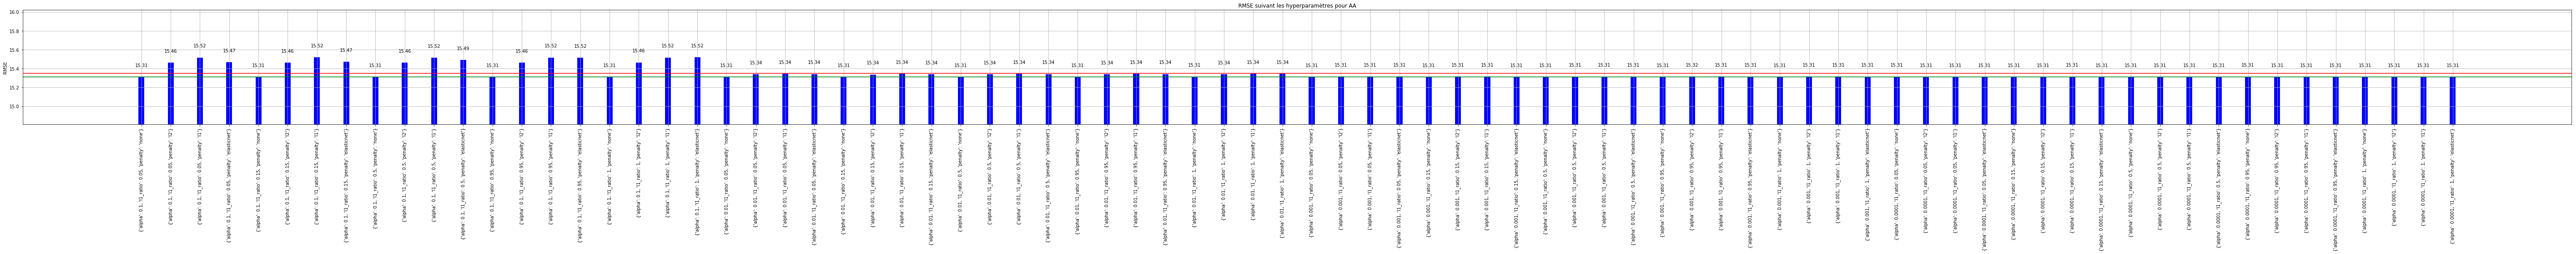

RMSE :  15.3025 pour {'alpha': 1e-07}
RMSE :  15.3025 pour {'alpha': 1e-06}
RMSE :  15.3025 pour {'alpha': 1e-05}
RMSE :  15.3025 pour {'alpha': 0.0001}
RMSE :  15.3025 pour {'alpha': 0.001}
RMSE :  15.3025 pour {'alpha': 0.01}
RMSE :  15.3025 pour {'alpha': 0.1}
RMSE :  15.3024 pour {'alpha': 1.0}
RMSE :  15.3022 pour {'alpha': 10.0}
RMSE :  15.3025 pour {'alpha': 100.0}
RMSE :  15.311 pour {'alpha': 1000.0}
RMSE :  15.3548 pour {'alpha': 10000.0}
RMSE :  15.5233 pour {'alpha': 100000.0}
RMSE :  15.6515 pour {'alpha': 1000000.0}
RMSE :  15.6733 pour {'alpha': 10000000.0}

Meilleur score :  15.3022 pour {'alpha': 10.0}


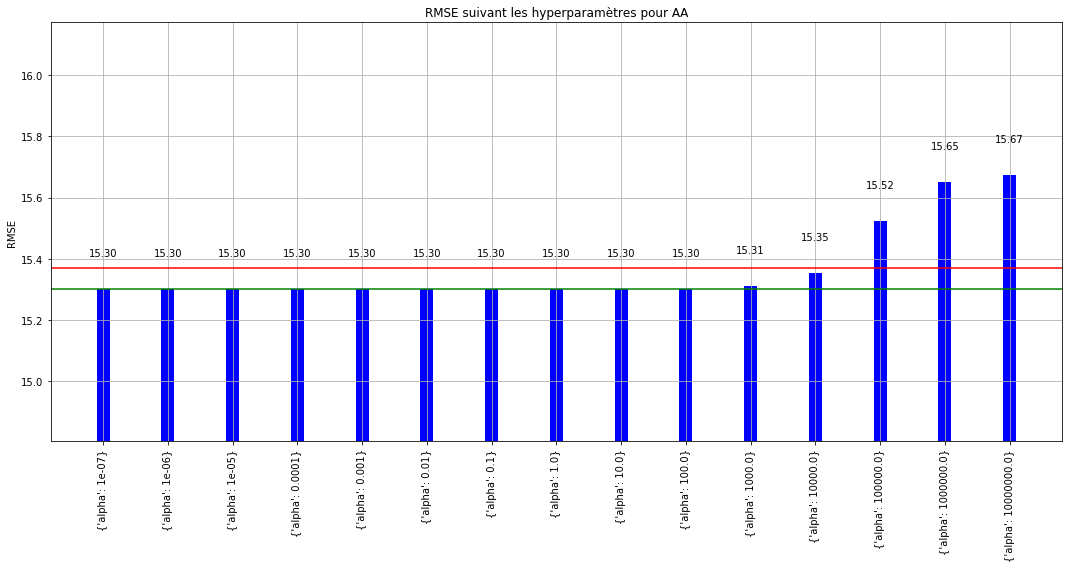

RMSE :  15.588 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  15.5888 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  15.5887 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  15.5538 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  15.5533 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  15.5552 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  15.5189 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  15.5178 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  15.5202 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  15.5178 pour {'max_depth': 5, 'min_samples_split': 4}


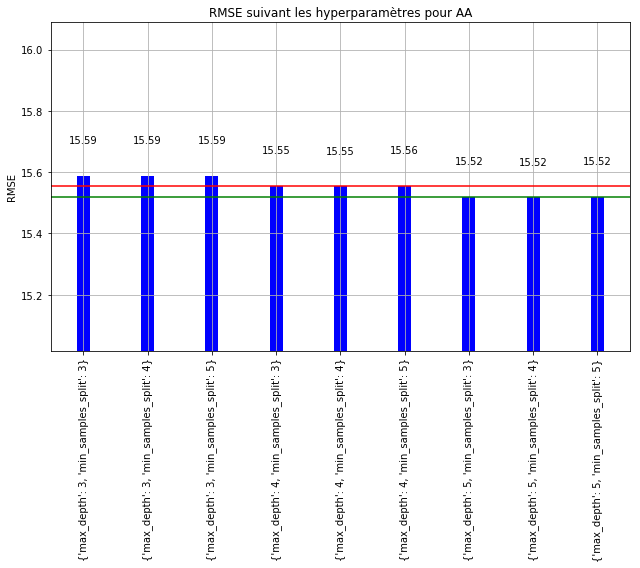

RMSE :  15.3705 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  15.3705 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  15.3705 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  15.3705 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  15.3131 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  15.3131 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  15.3131 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  15.3131 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  15.301 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  15.301 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  15.301 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  15.301 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  15.301 pour {'eps': 0.001, 'n_alphas': 2}


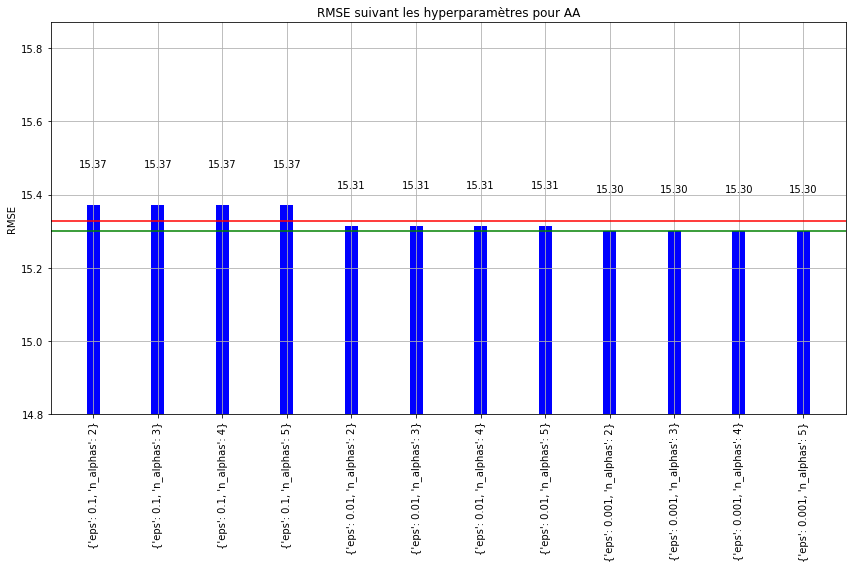



Pour la compagnie AS
RMSE :  14.1172 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  14.4087 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  14.4617 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  14.4115 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  14.1149 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  14.4085 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  14.4637 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  14.4197 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  14.117 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  14.4093 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  14.463 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  14.4457 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  14.1157 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  14.4082 pour {'alpha

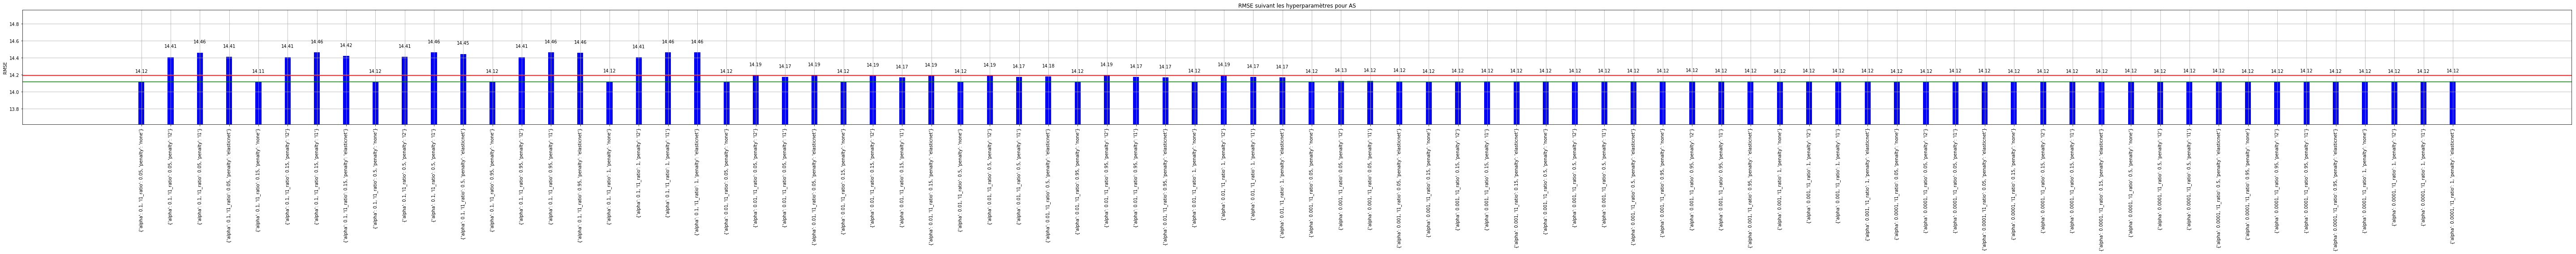

RMSE :  14.1195 pour {'alpha': 1e-07}
RMSE :  14.1195 pour {'alpha': 1e-06}
RMSE :  14.1195 pour {'alpha': 1e-05}
RMSE :  14.1195 pour {'alpha': 0.0001}
RMSE :  14.1195 pour {'alpha': 0.001}
RMSE :  14.1195 pour {'alpha': 0.01}
RMSE :  14.1195 pour {'alpha': 0.1}
RMSE :  14.1194 pour {'alpha': 1.0}
RMSE :  14.1191 pour {'alpha': 10.0}
RMSE :  14.1274 pour {'alpha': 100.0}
RMSE :  14.224 pour {'alpha': 1000.0}
RMSE :  14.4508 pour {'alpha': 10000.0}
RMSE :  14.627 pour {'alpha': 100000.0}
RMSE :  14.6659 pour {'alpha': 1000000.0}
RMSE :  14.6704 pour {'alpha': 10000000.0}

Meilleur score :  14.1191 pour {'alpha': 10.0}


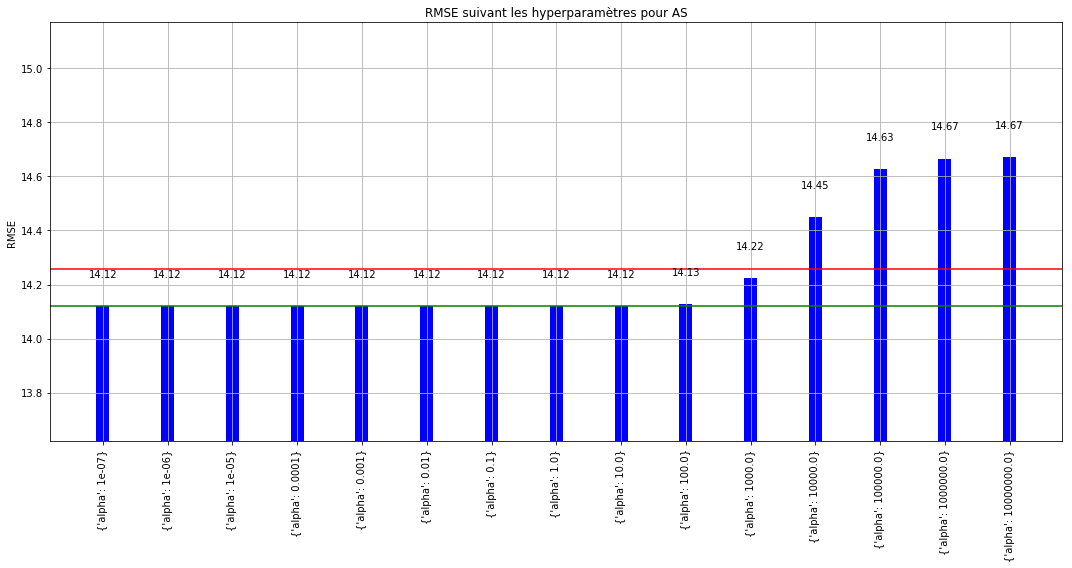

RMSE :  14.5142 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  14.5105 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  14.5132 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  14.4597 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  14.4573 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  14.4612 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  14.3988 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  14.3998 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  14.4046 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  14.3988 pour {'max_depth': 5, 'min_samples_split': 3}


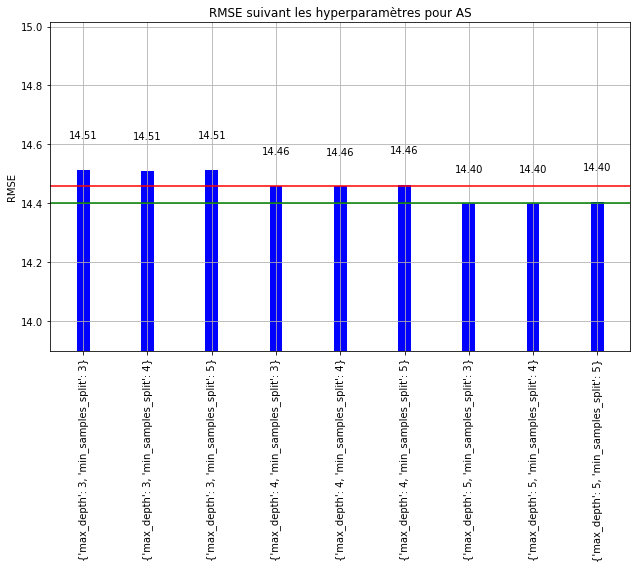

RMSE :  14.3524 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  14.3524 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  14.3524 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  14.3524 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  14.1048 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  14.1048 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  14.1048 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  14.1048 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  14.0871 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  14.0871 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  14.0871 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  14.0871 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  14.0871 pour {'eps': 0.001, 'n_alphas': 2}


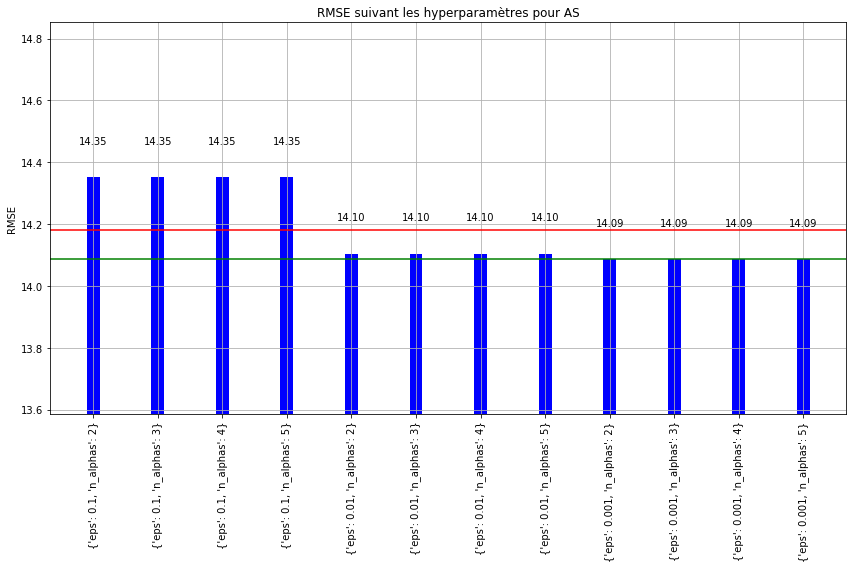



Pour la compagnie B6
RMSE :  16.4066 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  16.6265 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  16.6315 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  16.6328 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  16.41 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  16.6258 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  16.6286 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  16.6291 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  16.4115 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  16.6266 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  16.6308 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  16.636 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  16.4084 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  16.6263 pour {'alpha'

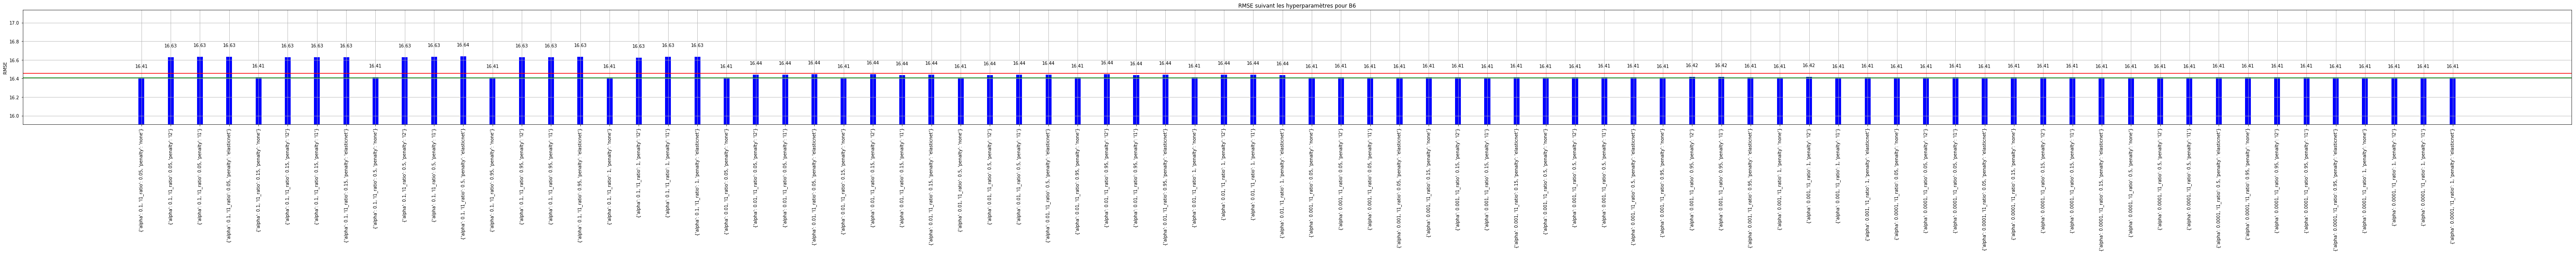

RMSE :  16.4112 pour {'alpha': 1e-07}
RMSE :  16.4112 pour {'alpha': 1e-06}
RMSE :  16.4112 pour {'alpha': 1e-05}
RMSE :  16.4112 pour {'alpha': 0.0001}
RMSE :  16.4112 pour {'alpha': 0.001}
RMSE :  16.4112 pour {'alpha': 0.01}
RMSE :  16.4112 pour {'alpha': 0.1}
RMSE :  16.4111 pour {'alpha': 1.0}
RMSE :  16.4108 pour {'alpha': 10.0}
RMSE :  16.4104 pour {'alpha': 100.0}
RMSE :  16.4346 pour {'alpha': 1000.0}
RMSE :  16.5912 pour {'alpha': 10000.0}
RMSE :  16.8459 pour {'alpha': 100000.0}
RMSE :  16.9141 pour {'alpha': 1000000.0}
RMSE :  16.9221 pour {'alpha': 10000000.0}

Meilleur score :  16.4104 pour {'alpha': 100.0}


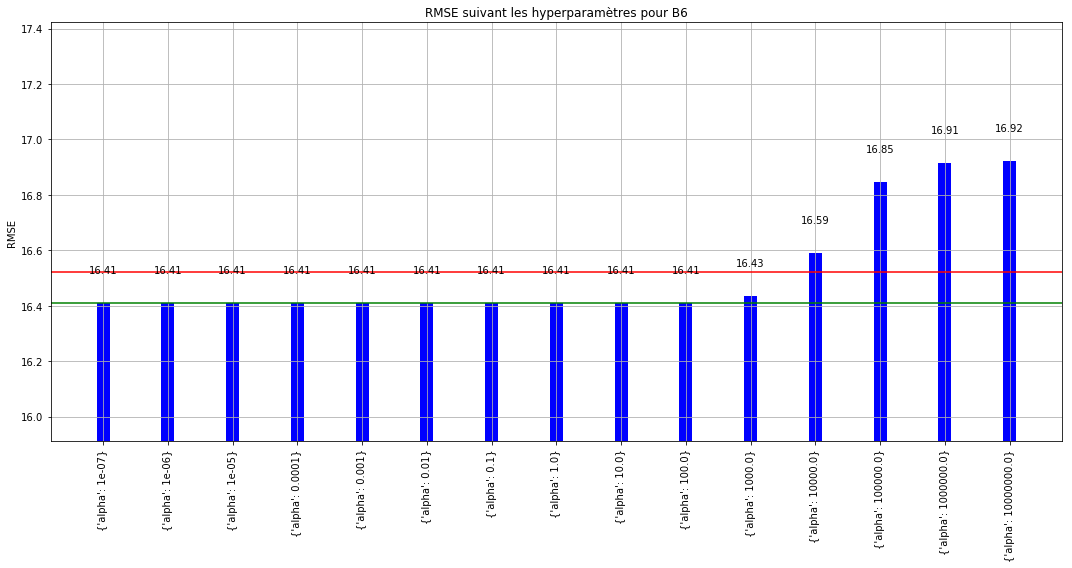

RMSE :  16.741 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  16.7359 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  16.7341 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  16.6937 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  16.6911 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  16.6945 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  16.65 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  16.651 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  16.6492 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  16.6492 pour {'max_depth': 5, 'min_samples_split': 5}


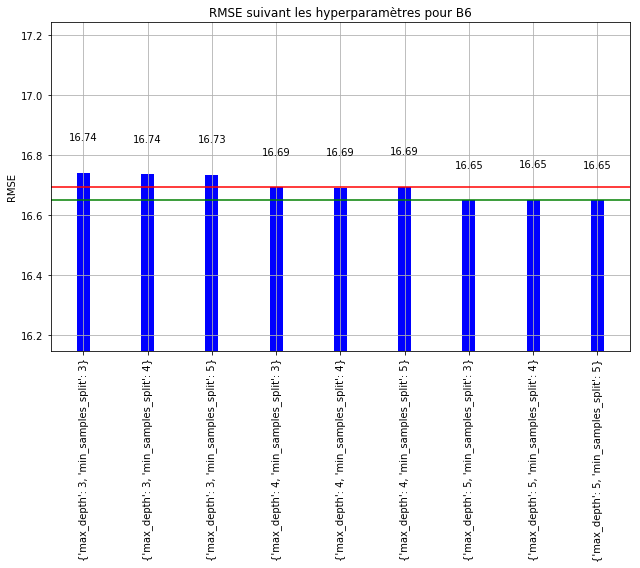

RMSE :  16.4832 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  16.4832 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  16.4832 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  16.4832 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  16.3897 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  16.3897 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  16.3897 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  16.3897 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  16.3834 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  16.3834 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  16.3834 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  16.3843 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  16.3834 pour {'eps': 0.001, 'n_alphas': 2}


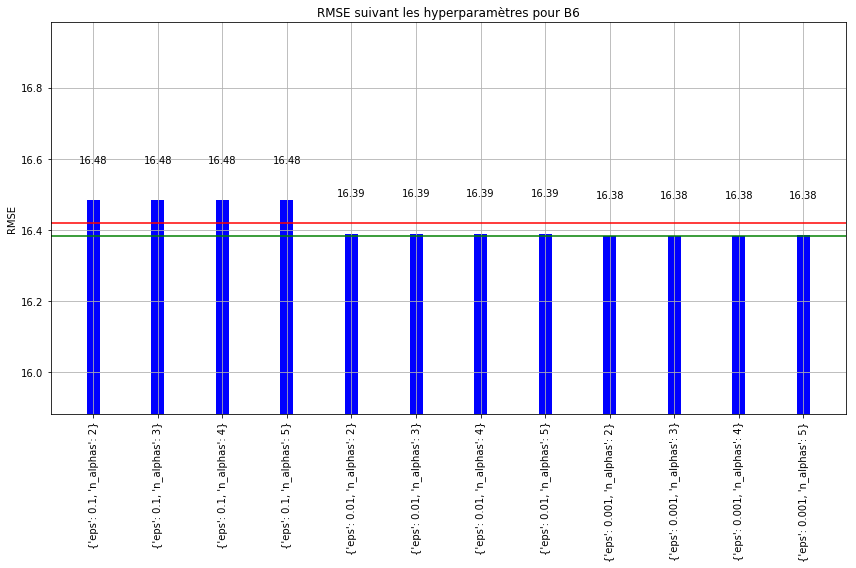



Pour la compagnie DL
RMSE :  14.0975 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  14.2223 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  14.2613 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  14.2273 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  14.0968 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  14.222 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  14.2648 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  14.2324 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  14.0981 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  14.2224 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  14.263 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  14.2451 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  14.096 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  14.2207 pour {'alpha'

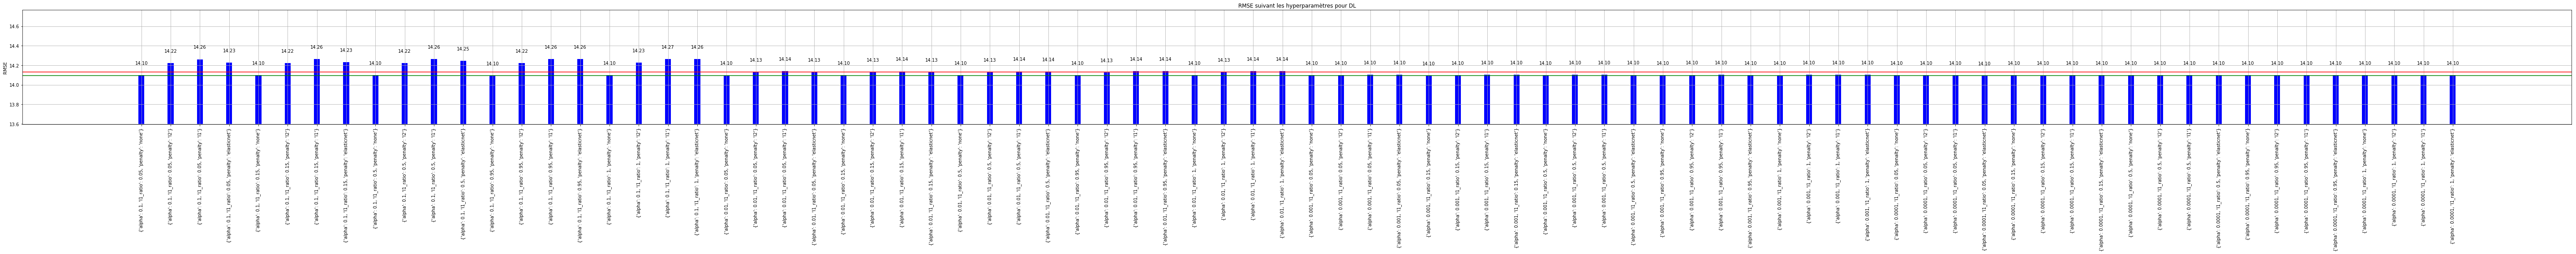

RMSE :  14.0881 pour {'alpha': 1e-07}
RMSE :  14.0881 pour {'alpha': 1e-06}
RMSE :  14.0881 pour {'alpha': 1e-05}
RMSE :  14.0881 pour {'alpha': 0.0001}
RMSE :  14.0881 pour {'alpha': 0.001}
RMSE :  14.0881 pour {'alpha': 0.01}
RMSE :  14.0881 pour {'alpha': 0.1}
RMSE :  14.0881 pour {'alpha': 1.0}
RMSE :  14.088 pour {'alpha': 10.0}
RMSE :  14.0887 pour {'alpha': 100.0}
RMSE :  14.101 pour {'alpha': 1000.0}
RMSE :  14.1447 pour {'alpha': 10000.0}
RMSE :  14.262 pour {'alpha': 100000.0}
RMSE :  14.3718 pour {'alpha': 1000000.0}
RMSE :  14.3979 pour {'alpha': 10000000.0}

Meilleur score :  14.088 pour {'alpha': 10.0}


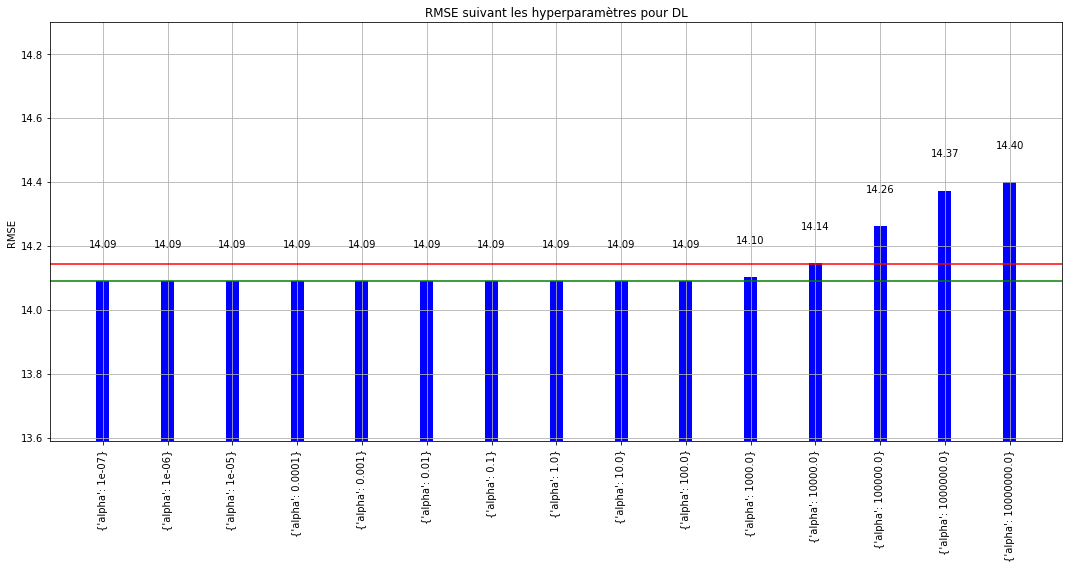

RMSE :  14.2675 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  14.2681 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  14.2689 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  14.2237 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  14.2209 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  14.226 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  14.1906 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  14.188 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  14.1905 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  14.188 pour {'max_depth': 5, 'min_samples_split': 4}


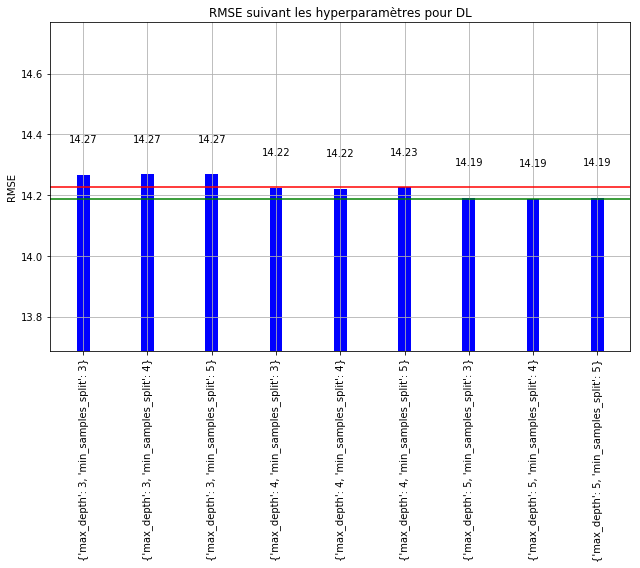

RMSE :  14.2122 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  14.2122 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  14.2122 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  14.2122 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  14.1364 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  14.1364 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  14.1364 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  14.1364 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  14.1042 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  14.1042 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  14.1042 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  14.1042 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  14.1042 pour {'eps': 0.001, 'n_alphas': 2}


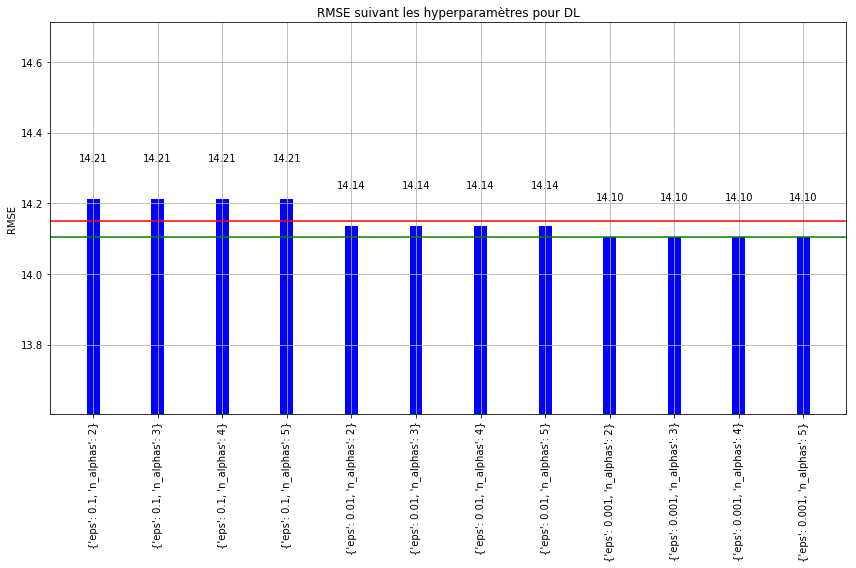



Pour la compagnie F9
RMSE :  16.5225 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  16.8233 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  16.7326 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  16.8163 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  16.521 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  16.8232 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  16.7324 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  16.8182 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  16.5196 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  16.8341 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  16.7313 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  16.7951 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  16.5262 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  16.8289 pour {'alph

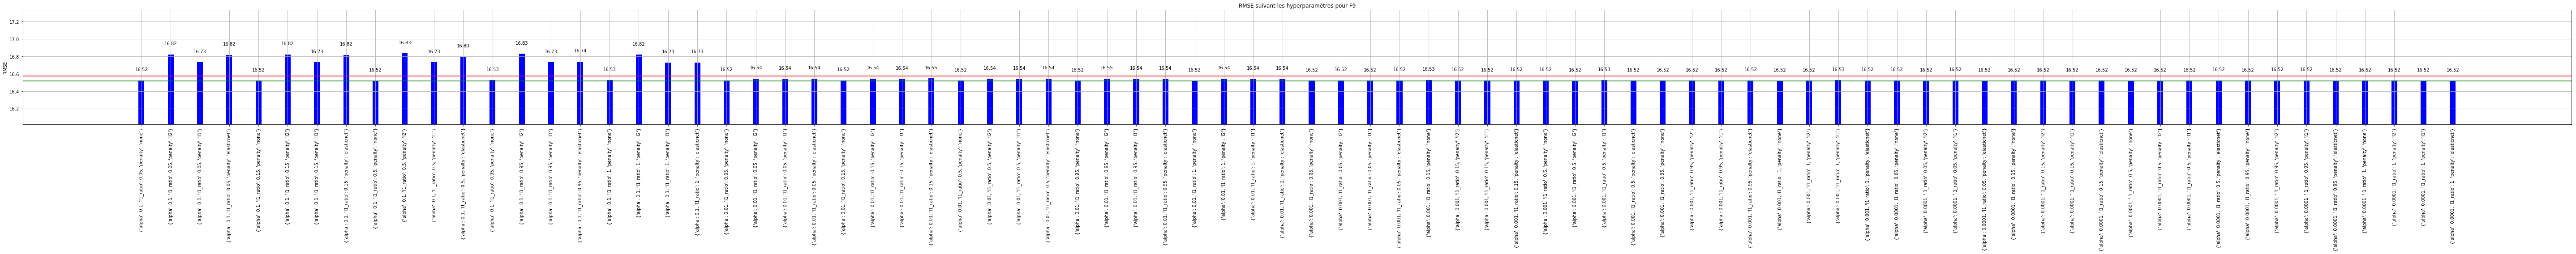

RMSE :  16.5616 pour {'alpha': 1e-07}
RMSE :  16.5616 pour {'alpha': 1e-06}
RMSE :  16.5616 pour {'alpha': 1e-05}
RMSE :  16.5616 pour {'alpha': 0.0001}
RMSE :  16.5616 pour {'alpha': 0.001}
RMSE :  16.5616 pour {'alpha': 0.01}
RMSE :  16.5616 pour {'alpha': 0.1}
RMSE :  16.5614 pour {'alpha': 1.0}
RMSE :  16.5599 pour {'alpha': 10.0}
RMSE :  16.5593 pour {'alpha': 100.0}
RMSE :  16.6272 pour {'alpha': 1000.0}
RMSE :  17.0551 pour {'alpha': 10000.0}
RMSE :  17.4091 pour {'alpha': 100000.0}
RMSE :  17.4689 pour {'alpha': 1000000.0}
RMSE :  17.4753 pour {'alpha': 10000000.0}

Meilleur score :  16.5593 pour {'alpha': 100.0}


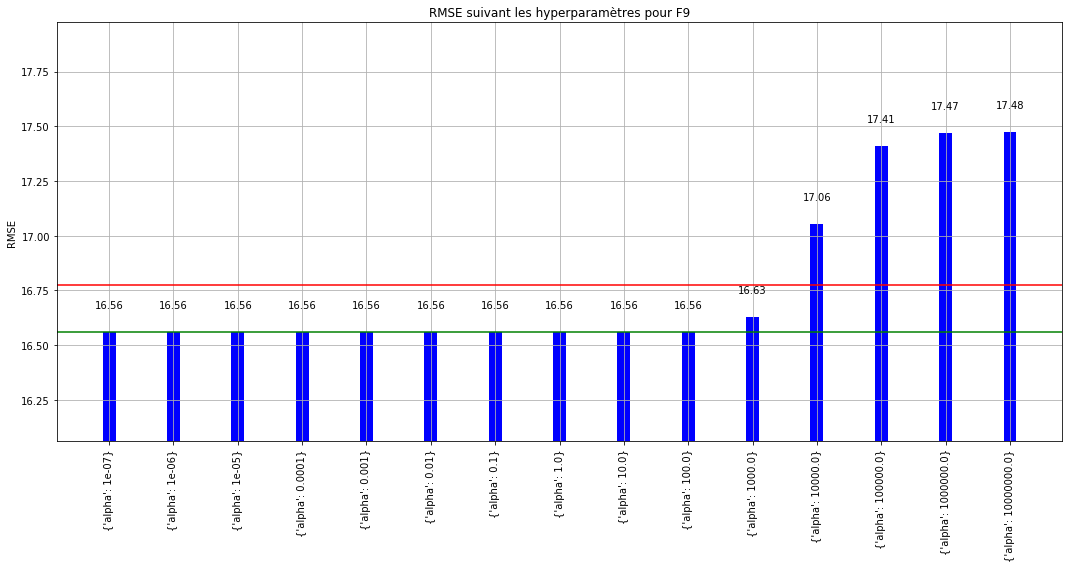

RMSE :  17.0518 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  17.0513 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  17.0553 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  16.9586 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  16.9555 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  16.9623 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  16.8685 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  16.8658 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  16.8648 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  16.8648 pour {'max_depth': 5, 'min_samples_split': 5}


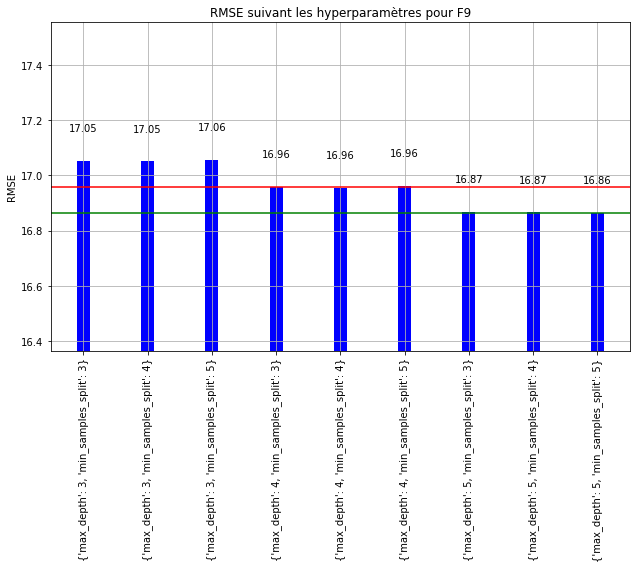

RMSE :  16.6792 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  16.6792 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  16.6792 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  16.6792 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  16.5368 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  16.5368 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  16.5368 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  16.5368 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  16.5316 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  16.5316 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  16.5321 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  16.5328 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  16.5316 pour {'eps': 0.001, 'n_alphas': 2}


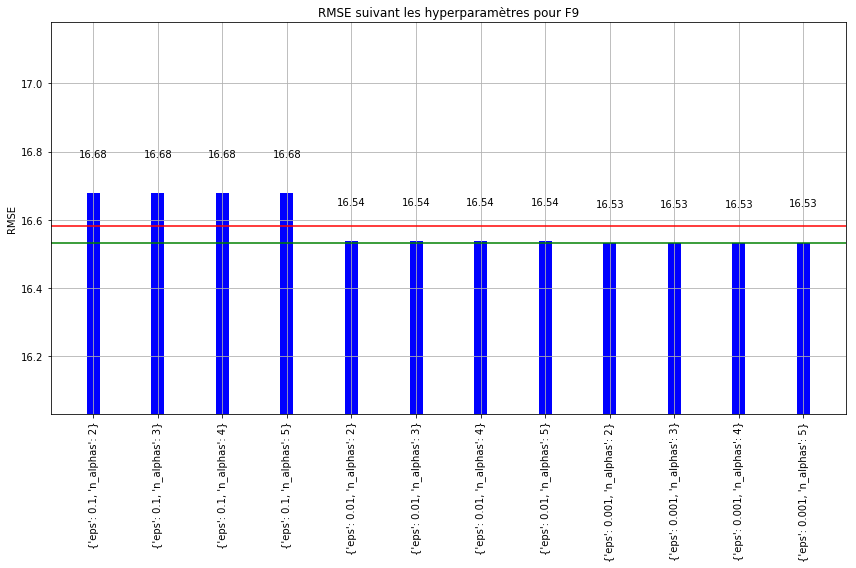



Pour la compagnie HA
RMSE :  10.6392 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  10.8217 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  10.9124 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  10.8245 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  10.6411 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  10.8238 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  10.9151 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  10.8325 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  10.6409 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  10.8245 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  10.9139 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  10.8683 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  10.6405 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  10.8221 pour {'alp

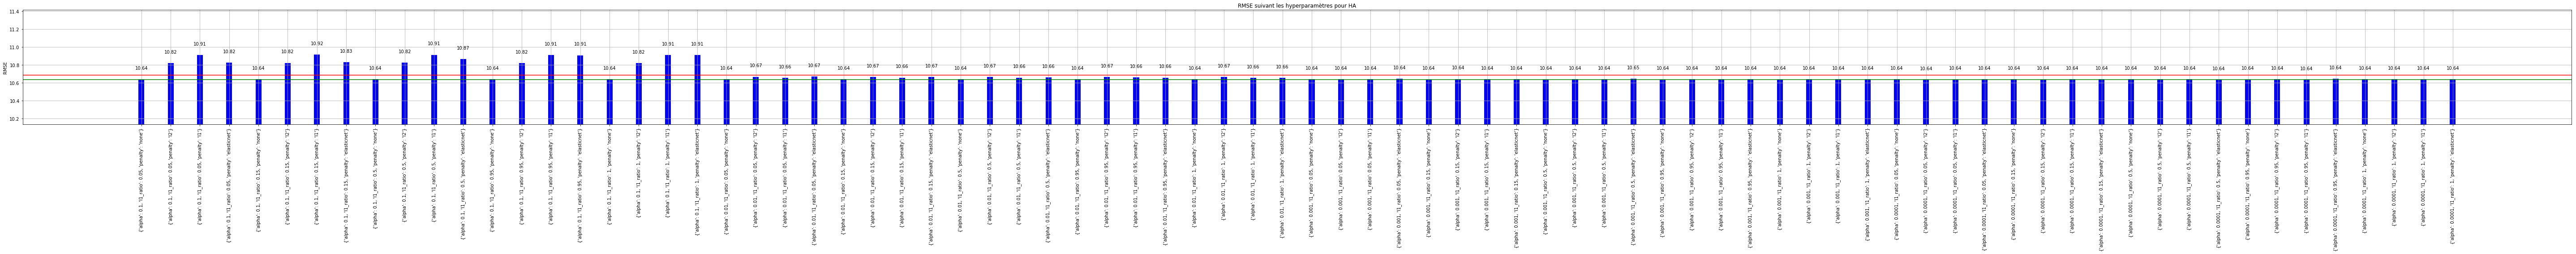

RMSE :  10.644 pour {'alpha': 1e-07}
RMSE :  10.644 pour {'alpha': 1e-06}
RMSE :  10.644 pour {'alpha': 1e-05}
RMSE :  10.644 pour {'alpha': 0.0001}
RMSE :  10.644 pour {'alpha': 0.001}
RMSE :  10.644 pour {'alpha': 0.01}
RMSE :  10.644 pour {'alpha': 0.1}
RMSE :  10.644 pour {'alpha': 1.0}
RMSE :  10.6437 pour {'alpha': 10.0}
RMSE :  10.647 pour {'alpha': 100.0}
RMSE :  10.7195 pour {'alpha': 1000.0}
RMSE :  10.9042 pour {'alpha': 10000.0}
RMSE :  10.994 pour {'alpha': 100000.0}
RMSE :  11.0083 pour {'alpha': 1000000.0}
RMSE :  11.0098 pour {'alpha': 10000000.0}

Meilleur score :  10.6437 pour {'alpha': 10.0}


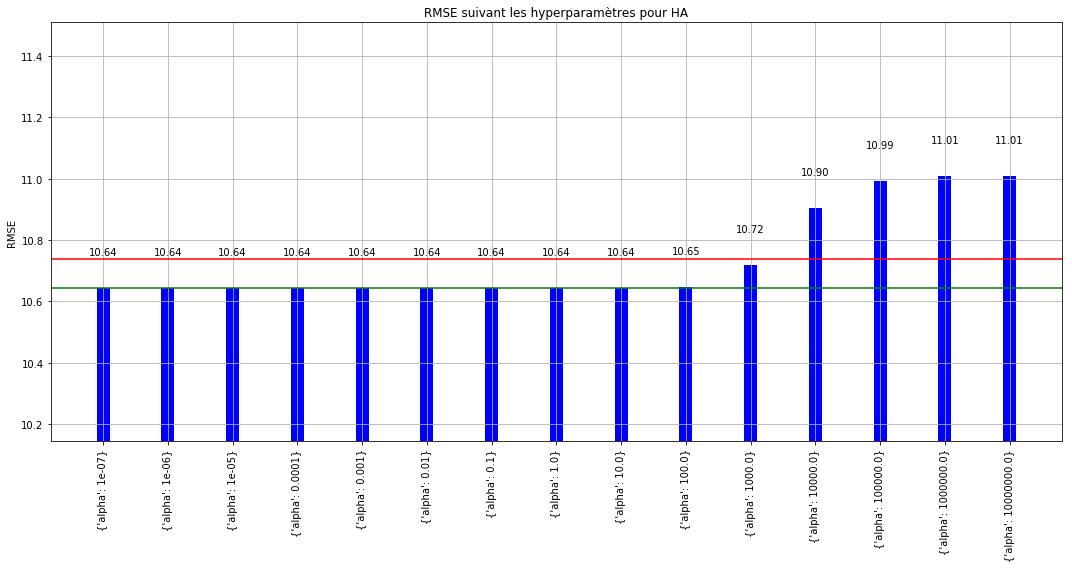

RMSE :  10.9191 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  10.9161 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  10.9171 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  10.8674 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  10.8741 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  10.8795 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  10.83 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  10.8352 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  10.8279 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  10.8279 pour {'max_depth': 5, 'min_samples_split': 5}


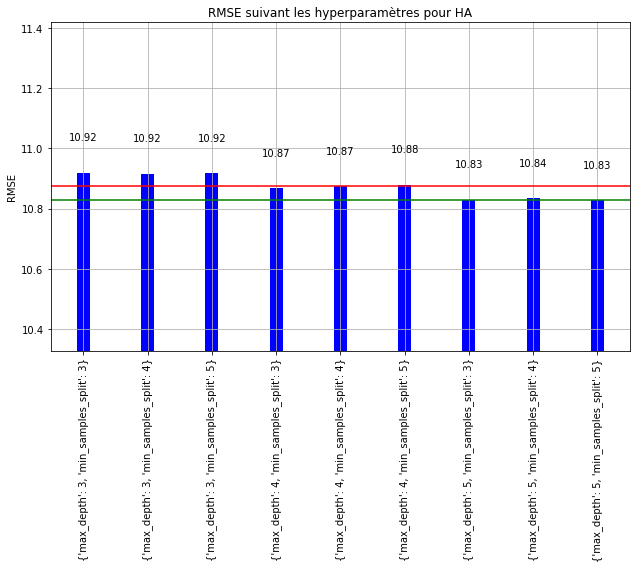

RMSE :  10.6754 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  10.6754 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  10.6754 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  10.6754 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  10.628 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  10.628 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  10.628 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  10.628 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  10.6286 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  10.6286 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  10.628 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  10.6281 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  10.628 pour {'eps': 0.01, 'n_alphas': 2}


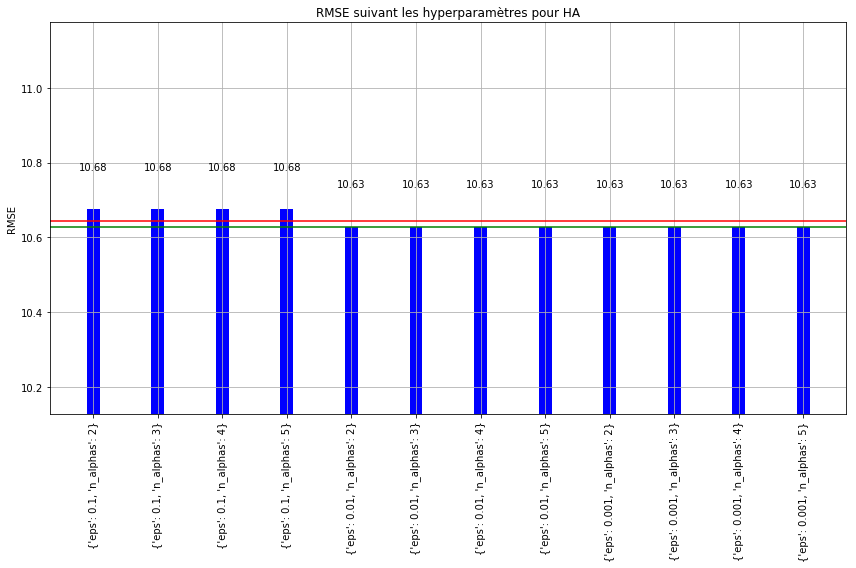



Pour la compagnie NK
RMSE :  15.6247 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  15.7788 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  15.7706 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  15.779 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  15.6285 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  15.7777 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  15.7776 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  15.7859 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  15.627 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  15.7752 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  15.771 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  15.7887 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  15.6253 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  15.775 pour {'alpha':

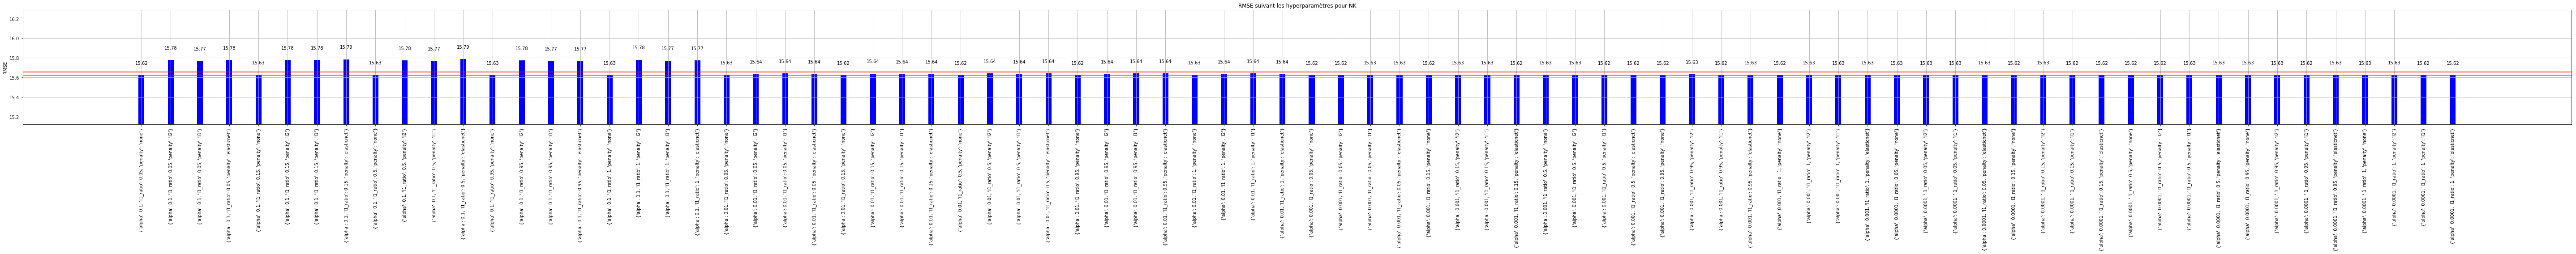

RMSE :  15.6058 pour {'alpha': 1e-07}
RMSE :  15.6058 pour {'alpha': 1e-06}
RMSE :  15.6058 pour {'alpha': 1e-05}
RMSE :  15.6058 pour {'alpha': 0.0001}
RMSE :  15.6058 pour {'alpha': 0.001}
RMSE :  15.6058 pour {'alpha': 0.01}
RMSE :  15.6058 pour {'alpha': 0.1}
RMSE :  15.6058 pour {'alpha': 1.0}
RMSE :  15.6055 pour {'alpha': 10.0}
RMSE :  15.607 pour {'alpha': 100.0}
RMSE :  15.6318 pour {'alpha': 1000.0}
RMSE :  15.7987 pour {'alpha': 10000.0}
RMSE :  15.9966 pour {'alpha': 100000.0}
RMSE :  16.0354 pour {'alpha': 1000000.0}
RMSE :  16.0396 pour {'alpha': 10000000.0}

Meilleur score :  15.6055 pour {'alpha': 10.0}


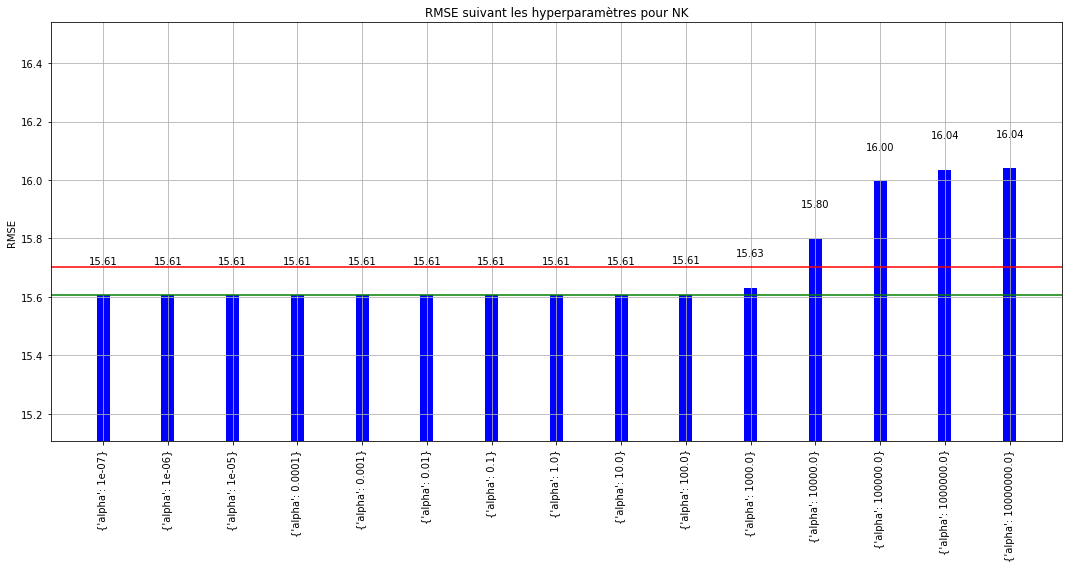

RMSE :  15.8443 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  15.8457 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  15.8466 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  15.7922 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  15.7911 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  15.7935 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  15.761 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  15.7614 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  15.7593 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  15.7593 pour {'max_depth': 5, 'min_samples_split': 5}


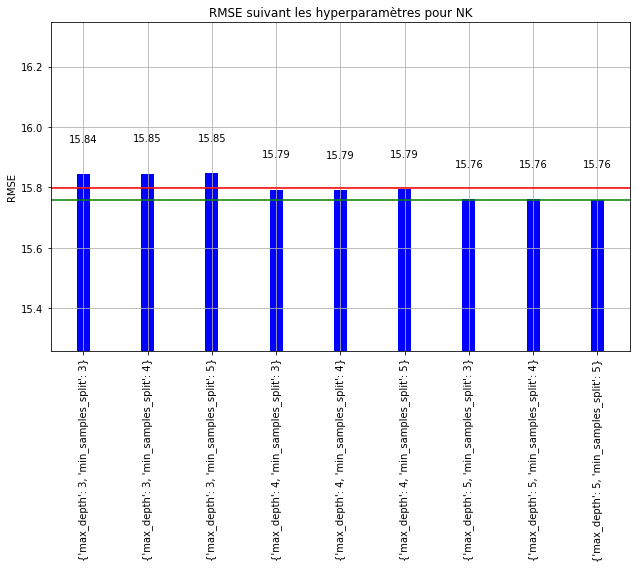

RMSE :  15.6554 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  15.6554 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  15.6554 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  15.6554 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  15.593 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  15.593 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  15.593 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  15.593 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  15.5918 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  15.5918 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  15.5918 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  15.5915 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  15.5915 pour {'eps': 0.001, 'n_alphas': 5}


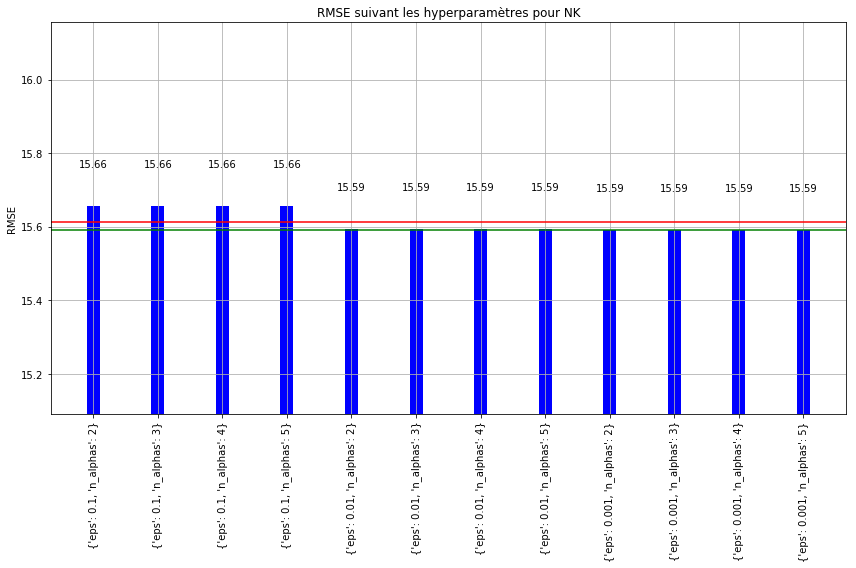



Pour la compagnie EV
RMSE :  14.6806 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  14.803 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  14.8346 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  14.807 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  14.6799 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  14.8041 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  14.8357 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  14.8135 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  14.6816 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  14.8038 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  14.8338 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  14.8215 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  14.6793 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  14.8026 pour {'alpha

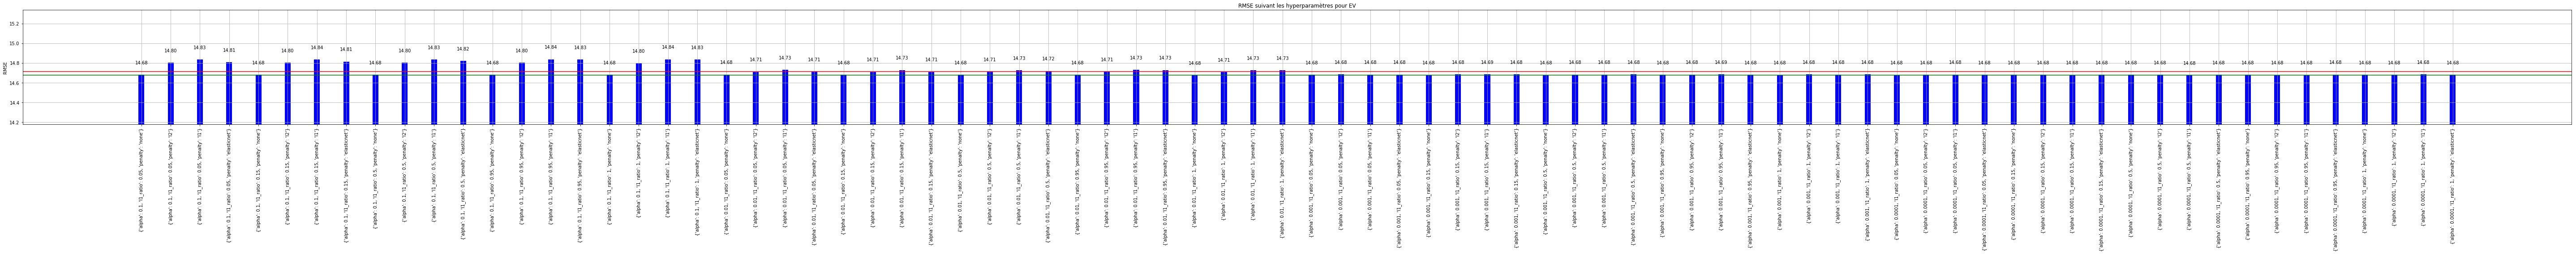

RMSE :  14.6616 pour {'alpha': 1e-07}
RMSE :  14.6616 pour {'alpha': 1e-06}
RMSE :  14.6616 pour {'alpha': 1e-05}
RMSE :  14.6616 pour {'alpha': 0.0001}
RMSE :  14.6616 pour {'alpha': 0.001}
RMSE :  14.6616 pour {'alpha': 0.01}
RMSE :  14.6616 pour {'alpha': 0.1}
RMSE :  14.6615 pour {'alpha': 1.0}
RMSE :  14.661 pour {'alpha': 10.0}
RMSE :  14.6624 pour {'alpha': 100.0}
RMSE :  14.6829 pour {'alpha': 1000.0}
RMSE :  14.7438 pour {'alpha': 10000.0}
RMSE :  14.8847 pour {'alpha': 100000.0}
RMSE :  14.95 pour {'alpha': 1000000.0}
RMSE :  14.9589 pour {'alpha': 10000000.0}

Meilleur score :  14.661 pour {'alpha': 10.0}


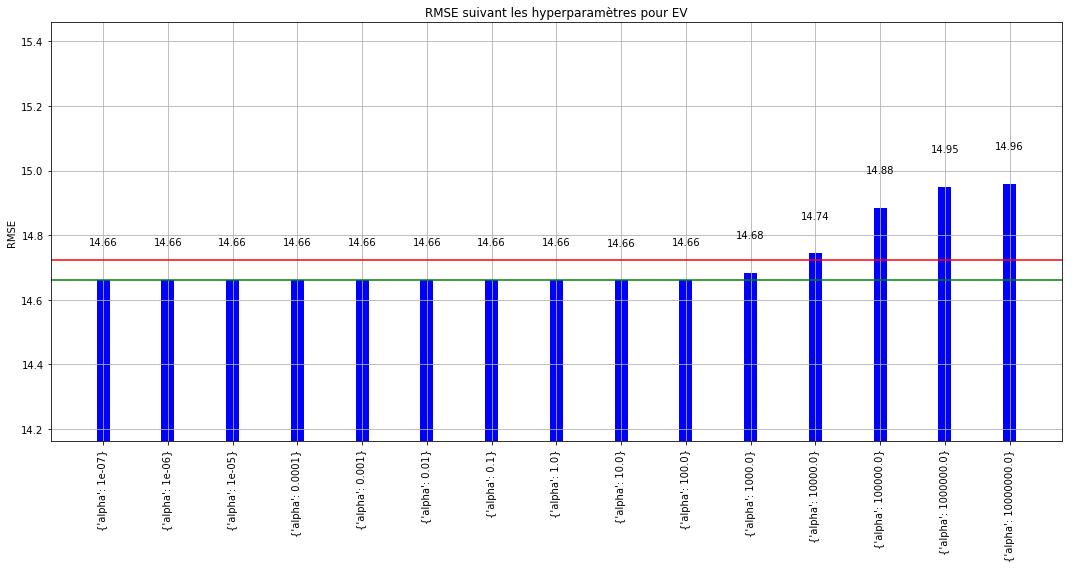

RMSE :  14.8407 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  14.8373 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  14.8369 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  14.8142 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  14.8142 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  14.8141 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  14.7876 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  14.7896 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  14.7883 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  14.7876 pour {'max_depth': 5, 'min_samples_split': 3}


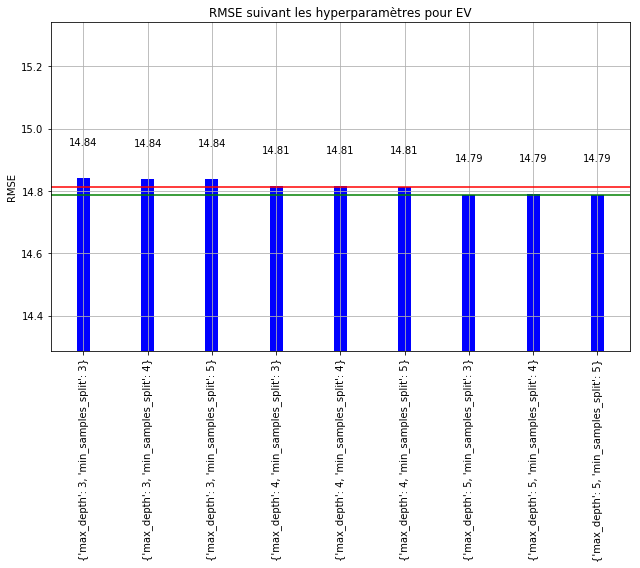

RMSE :  14.7374 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  14.7374 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  14.7374 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  14.7374 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  14.6728 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  14.6728 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  14.6728 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  14.6728 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  14.6499 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  14.6499 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  14.6499 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  14.6499 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  14.6499 pour {'eps': 0.001, 'n_alphas': 2}


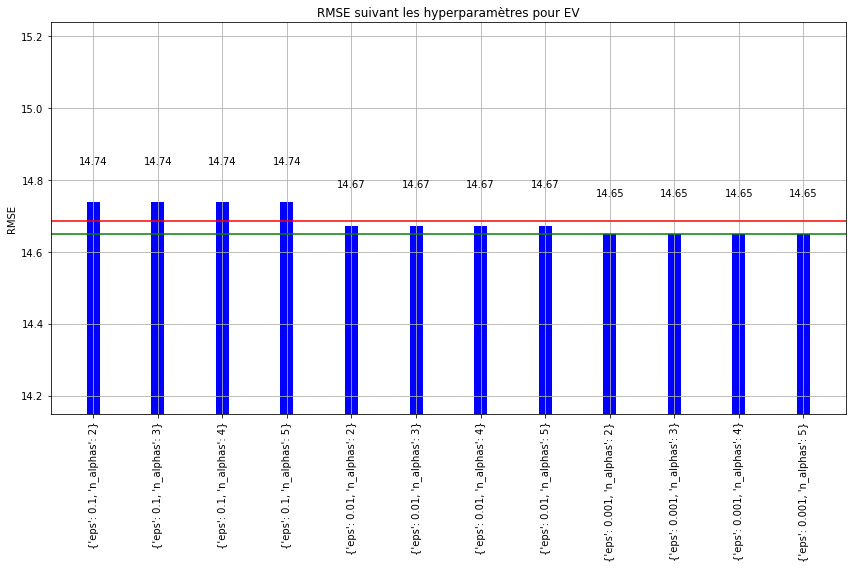



Pour la compagnie OO
RMSE :  13.9953 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  14.1549 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  14.2097 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  14.1598 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  13.9945 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  14.1566 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  14.208 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  14.169 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  13.9931 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  14.1558 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  14.2109 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  14.1914 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  13.9951 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  14.1569 pour {'alpha

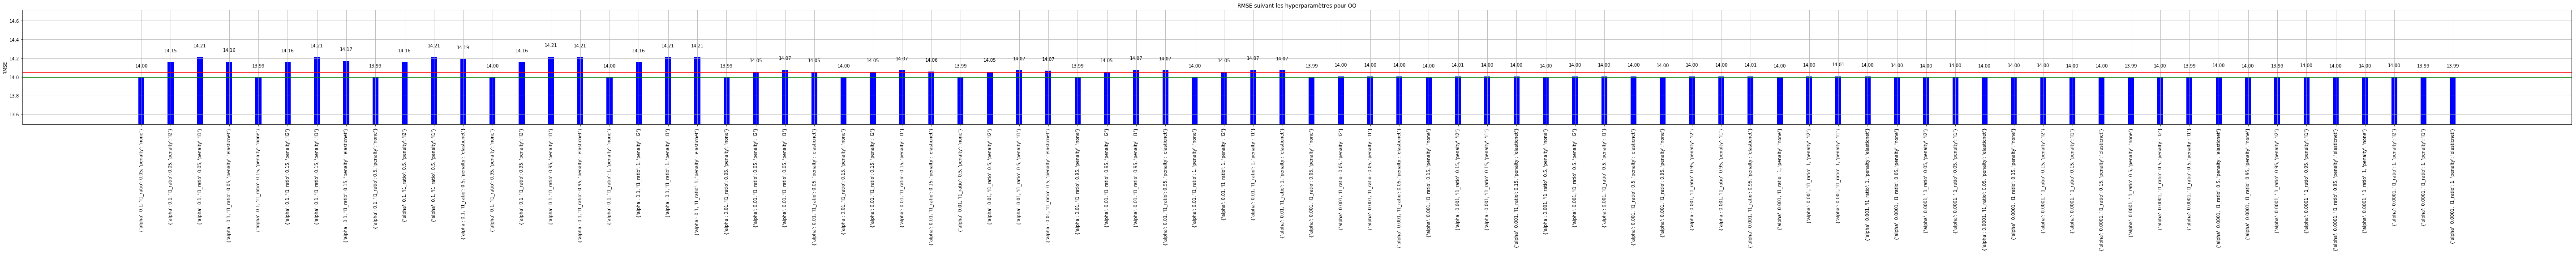

RMSE :  13.9787 pour {'alpha': 1e-07}
RMSE :  13.9787 pour {'alpha': 1e-06}
RMSE :  13.9787 pour {'alpha': 1e-05}
RMSE :  13.9787 pour {'alpha': 0.0001}
RMSE :  13.9787 pour {'alpha': 0.001}
RMSE :  13.9787 pour {'alpha': 0.01}
RMSE :  13.9787 pour {'alpha': 0.1}
RMSE :  13.9785 pour {'alpha': 1.0}
RMSE :  13.9779 pour {'alpha': 10.0}
RMSE :  13.9806 pour {'alpha': 100.0}
RMSE :  14.0167 pour {'alpha': 1000.0}
RMSE :  14.0906 pour {'alpha': 10000.0}
RMSE :  14.2229 pour {'alpha': 100000.0}
RMSE :  14.2867 pour {'alpha': 1000000.0}
RMSE :  14.2956 pour {'alpha': 10000000.0}

Meilleur score :  13.9779 pour {'alpha': 10.0}


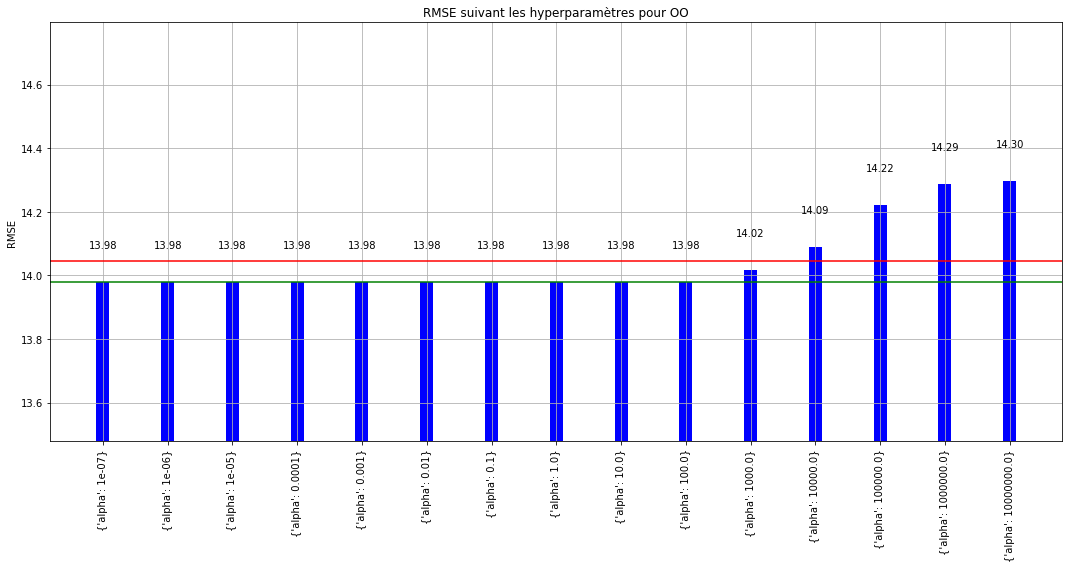

RMSE :  14.2208 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  14.2204 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  14.2217 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  14.1961 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  14.1941 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  14.1937 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  14.1698 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  14.169 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  14.171 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  14.169 pour {'max_depth': 5, 'min_samples_split': 4}


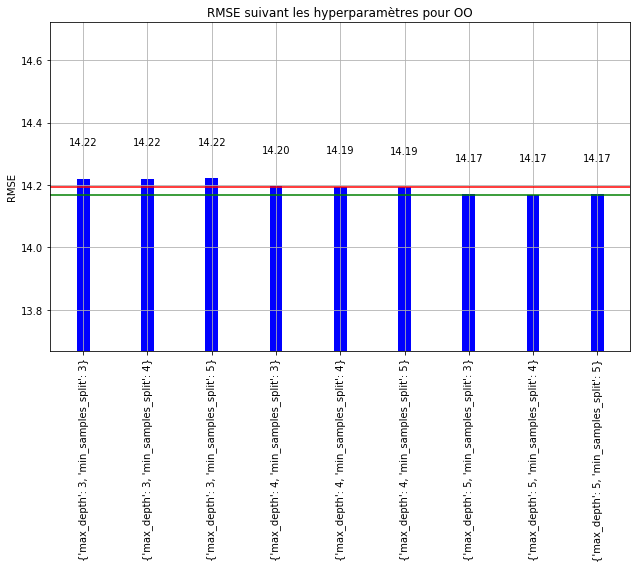

RMSE :  14.1024 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  14.1024 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  14.1024 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  14.1024 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  14.0063 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  14.0063 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  14.0063 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  14.0063 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  13.9833 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  13.9833 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  13.9833 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  13.9833 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  13.9833 pour {'eps': 0.001, 'n_alphas': 2}


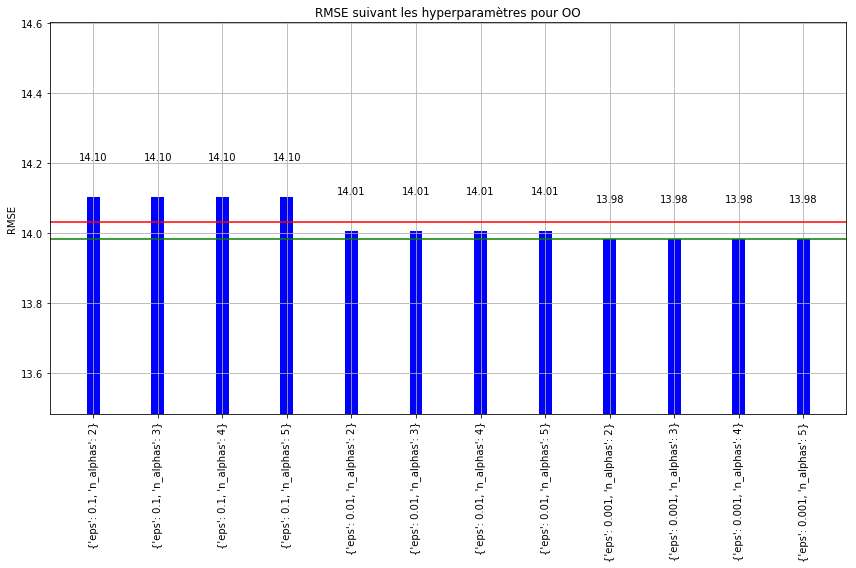



Pour la compagnie UA
RMSE :  15.6413 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  15.8155 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  15.8319 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  15.8237 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  15.6411 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  15.8179 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  15.8342 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  15.8209 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  15.6412 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  15.8198 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  15.8287 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  15.8302 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  15.6394 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  15.8182 pour {'alp

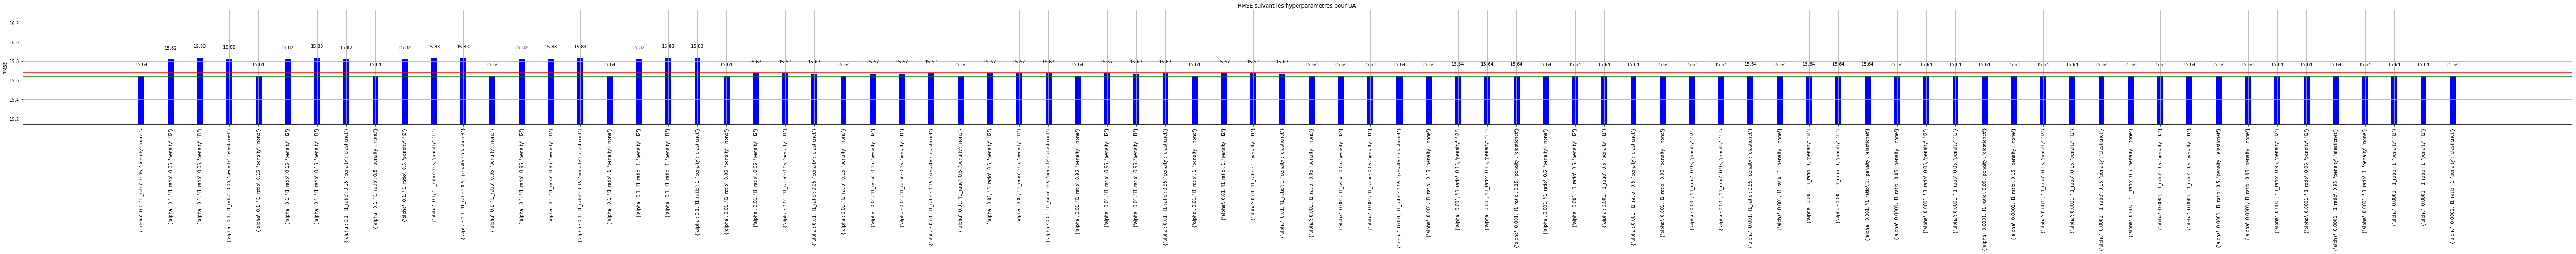

RMSE :  15.6294 pour {'alpha': 1e-07}
RMSE :  15.6294 pour {'alpha': 1e-06}
RMSE :  15.6294 pour {'alpha': 1e-05}
RMSE :  15.6294 pour {'alpha': 0.0001}
RMSE :  15.6294 pour {'alpha': 0.001}
RMSE :  15.6294 pour {'alpha': 0.01}
RMSE :  15.6294 pour {'alpha': 0.1}
RMSE :  15.6293 pour {'alpha': 1.0}
RMSE :  15.6291 pour {'alpha': 10.0}
RMSE :  15.6306 pour {'alpha': 100.0}
RMSE :  15.6462 pour {'alpha': 1000.0}
RMSE :  15.7203 pour {'alpha': 10000.0}
RMSE :  15.9439 pour {'alpha': 100000.0}
RMSE :  16.0575 pour {'alpha': 1000000.0}
RMSE :  16.0735 pour {'alpha': 10000000.0}

Meilleur score :  15.6291 pour {'alpha': 10.0}


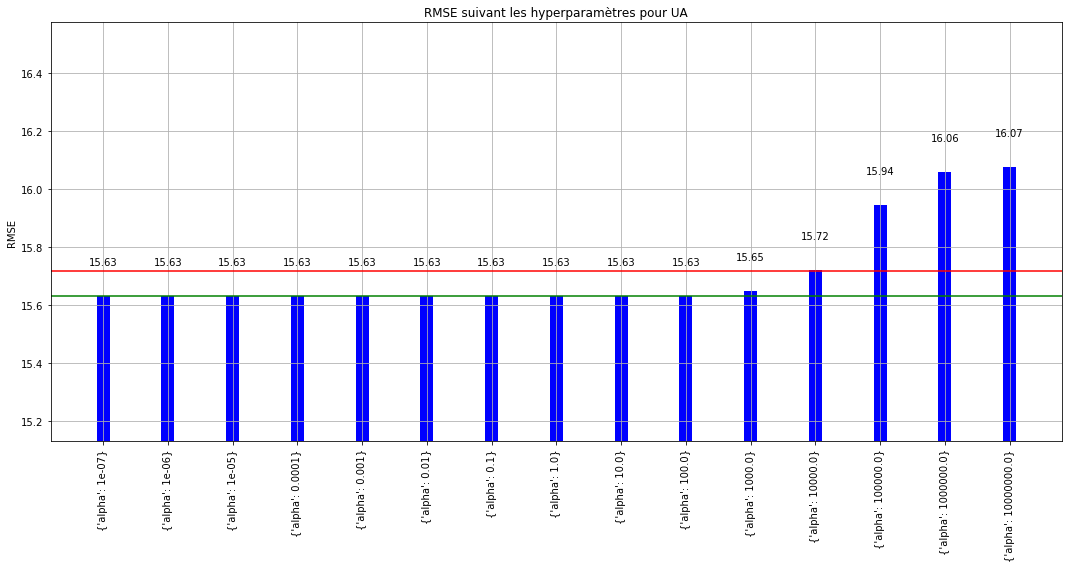

RMSE :  15.9321 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  15.9347 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  15.9312 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  15.8864 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  15.8825 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  15.8915 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  15.8403 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  15.8405 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  15.845 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  15.8403 pour {'max_depth': 5, 'min_samples_split': 3}


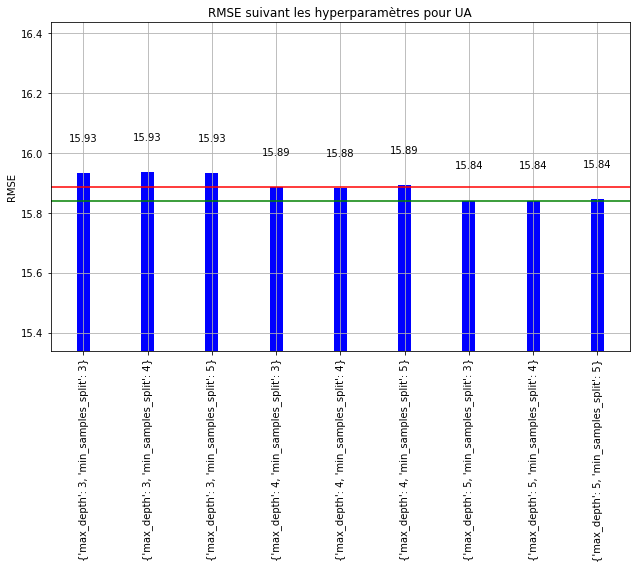

RMSE :  15.7137 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  15.7137 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  15.7137 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  15.7137 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  15.6451 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  15.6451 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  15.6451 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  15.6451 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  15.631 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  15.631 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  15.631 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  15.631 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  15.631 pour {'eps': 0.001, 'n_alphas': 2}


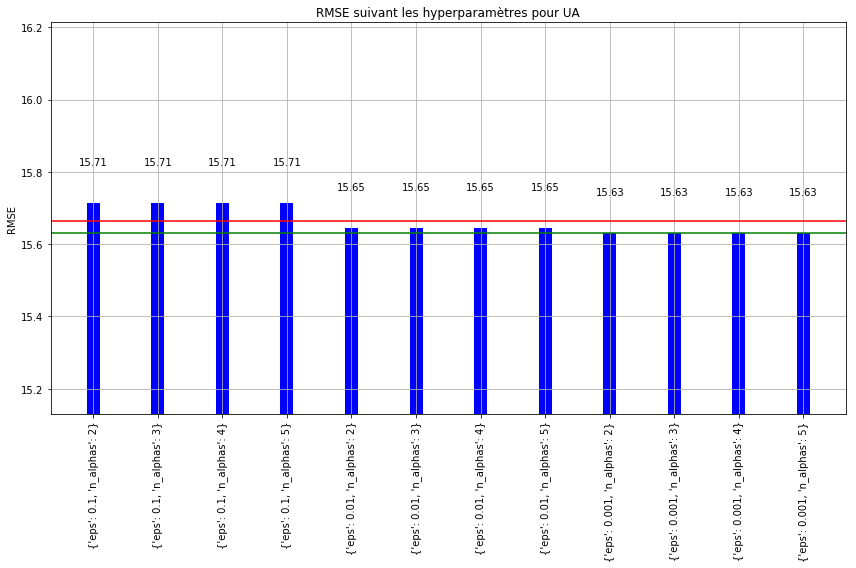



Pour la compagnie VX
RMSE :  15.4245 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  15.7751 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  15.7373 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  15.766 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  15.428 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  15.7698 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  15.7376 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  15.7754 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  15.4212 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  15.765 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  15.7383 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  15.763 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  15.4227 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  15.7652 pour {'alpha':

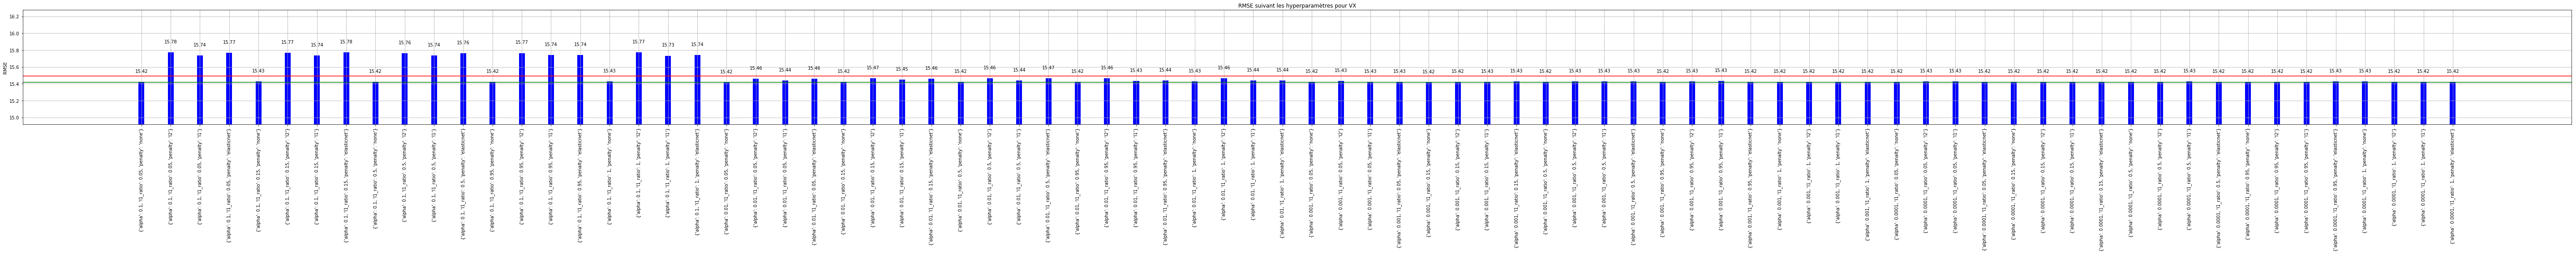

RMSE :  15.3255 pour {'alpha': 1e-07}
RMSE :  15.3255 pour {'alpha': 1e-06}
RMSE :  15.3255 pour {'alpha': 1e-05}
RMSE :  15.3255 pour {'alpha': 0.0001}
RMSE :  15.3255 pour {'alpha': 0.001}
RMSE :  15.3255 pour {'alpha': 0.01}
RMSE :  15.3255 pour {'alpha': 0.1}
RMSE :  15.3255 pour {'alpha': 1.0}
RMSE :  15.3253 pour {'alpha': 10.0}
RMSE :  15.3334 pour {'alpha': 100.0}
RMSE :  15.4738 pour {'alpha': 1000.0}
RMSE :  15.92 pour {'alpha': 10000.0}
RMSE :  16.1766 pour {'alpha': 100000.0}
RMSE :  16.2172 pour {'alpha': 1000000.0}
RMSE :  16.2216 pour {'alpha': 10000000.0}

Meilleur score :  15.3253 pour {'alpha': 10.0}


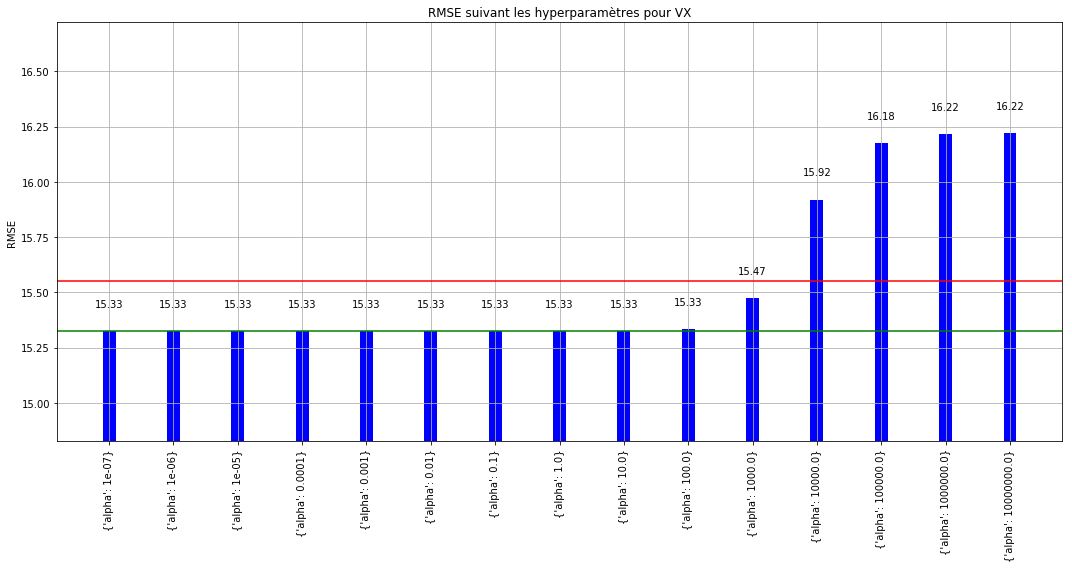

RMSE :  15.8525 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  15.8579 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  15.8535 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  15.751 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  15.7435 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  15.7489 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  15.6729 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  15.6716 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  15.6718 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  15.6716 pour {'max_depth': 5, 'min_samples_split': 4}


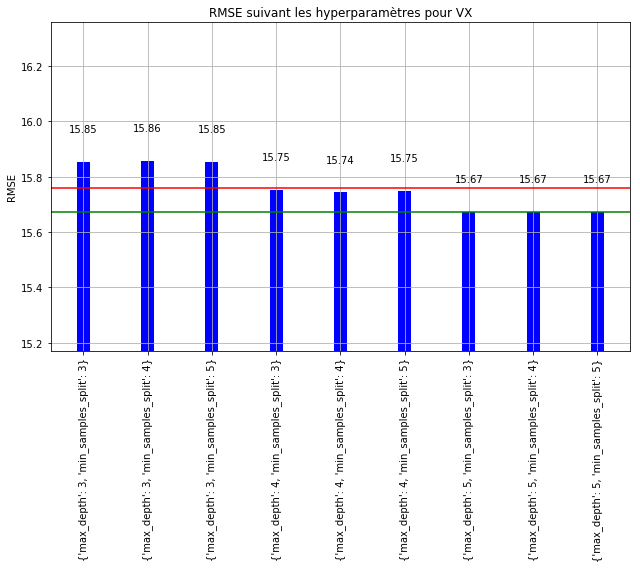

RMSE :  15.4767 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  15.4767 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  15.4767 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  15.4767 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  15.333 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  15.333 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  15.333 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  15.333 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  15.3302 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  15.3302 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  15.3302 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  15.3302 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  15.3302 pour {'eps': 0.001, 'n_alphas': 2}


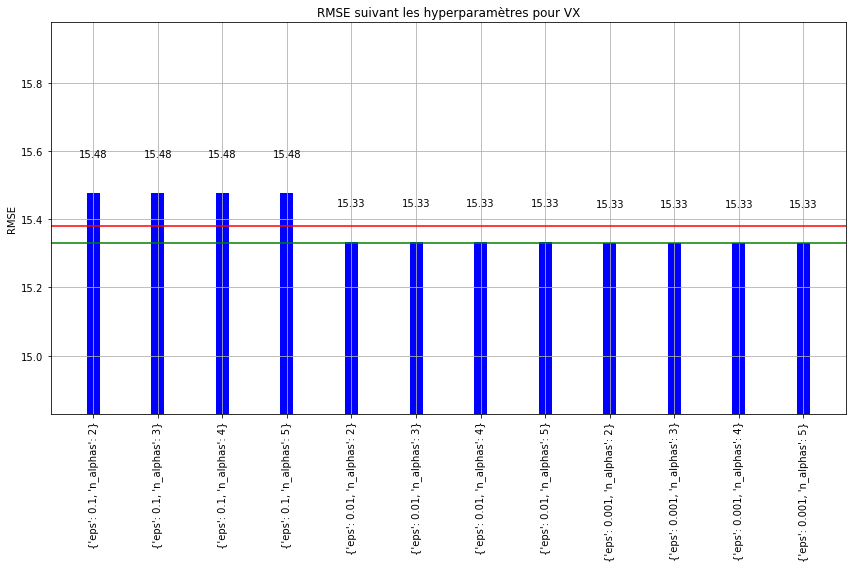



Pour la compagnie WN
RMSE :  13.4666 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'none'}
RMSE :  13.8545 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l2'}
RMSE :  13.825 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'l1'}
RMSE :  13.8572 pour {'alpha': 0.1, 'l1_ratio': 0.05, 'penalty': 'elasticnet'}
RMSE :  13.4663 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'none'}
RMSE :  13.8592 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l2'}
RMSE :  13.822 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'l1'}
RMSE :  13.8641 pour {'alpha': 0.1, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}
RMSE :  13.4664 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'none'}
RMSE :  13.8588 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l2'}
RMSE :  13.8198 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'l1'}
RMSE :  13.8741 pour {'alpha': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
RMSE :  13.4661 pour {'alpha': 0.1, 'l1_ratio': 0.95, 'penalty': 'none'}
RMSE :  13.8559 pour {'alpha

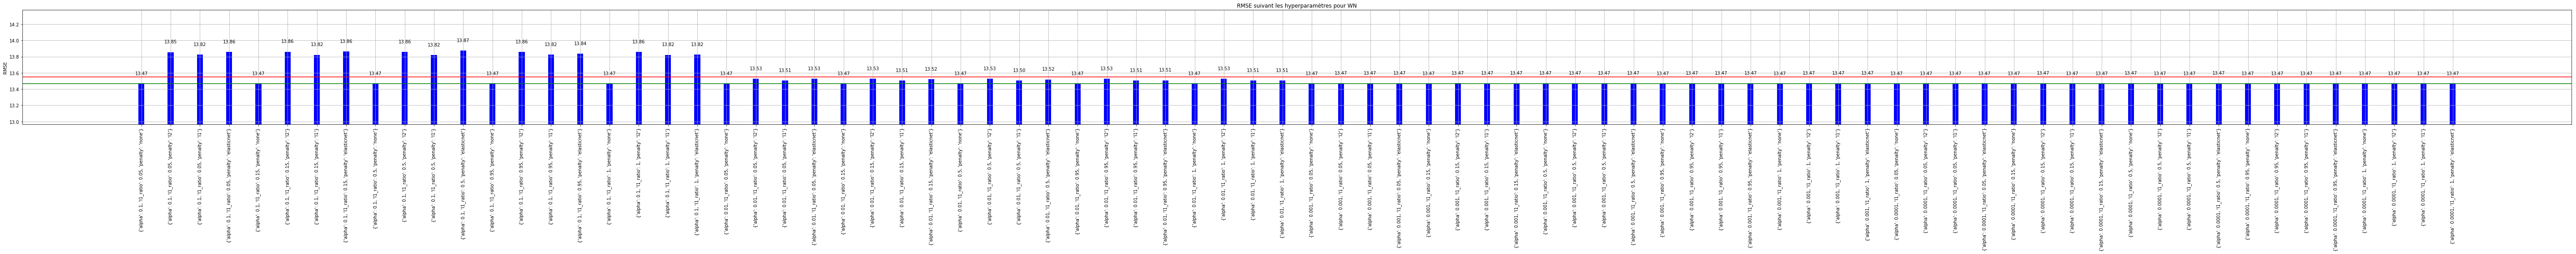

RMSE :  13.4372 pour {'alpha': 1e-07}
RMSE :  13.4372 pour {'alpha': 1e-06}
RMSE :  13.4372 pour {'alpha': 1e-05}
RMSE :  13.4372 pour {'alpha': 0.0001}
RMSE :  13.4372 pour {'alpha': 0.001}
RMSE :  13.4372 pour {'alpha': 0.01}
RMSE :  13.4372 pour {'alpha': 0.1}
RMSE :  13.4372 pour {'alpha': 1.0}
RMSE :  13.4372 pour {'alpha': 10.0}
RMSE :  13.4372 pour {'alpha': 100.0}
RMSE :  13.4434 pour {'alpha': 1000.0}
RMSE :  13.5212 pour {'alpha': 10000.0}
RMSE :  13.9019 pour {'alpha': 100000.0}
RMSE :  14.2198 pour {'alpha': 1000000.0}
RMSE :  14.2749 pour {'alpha': 10000000.0}

Meilleur score :  13.4372 pour {'alpha': 10.0}


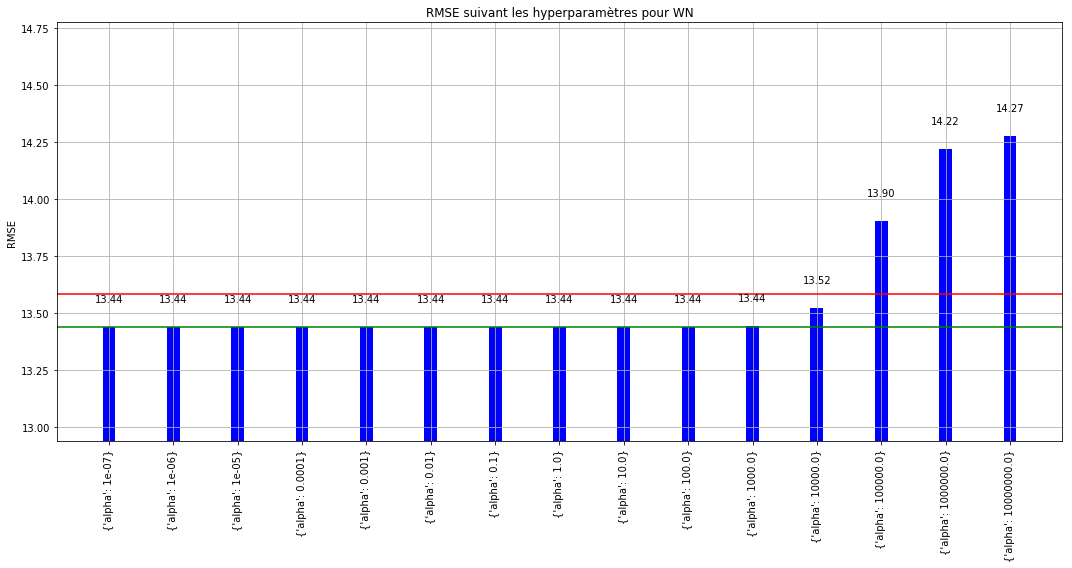

RMSE :  14.0389 pour {'max_depth': 3, 'min_samples_split': 3}
RMSE :  14.0311 pour {'max_depth': 3, 'min_samples_split': 4}
RMSE :  14.0326 pour {'max_depth': 3, 'min_samples_split': 5}
RMSE :  13.9757 pour {'max_depth': 4, 'min_samples_split': 3}
RMSE :  13.9701 pour {'max_depth': 4, 'min_samples_split': 4}
RMSE :  13.975 pour {'max_depth': 4, 'min_samples_split': 5}
RMSE :  13.9322 pour {'max_depth': 5, 'min_samples_split': 3}
RMSE :  13.9317 pour {'max_depth': 5, 'min_samples_split': 4}
RMSE :  13.932 pour {'max_depth': 5, 'min_samples_split': 5}

Meilleur score :  13.9317 pour {'max_depth': 5, 'min_samples_split': 4}


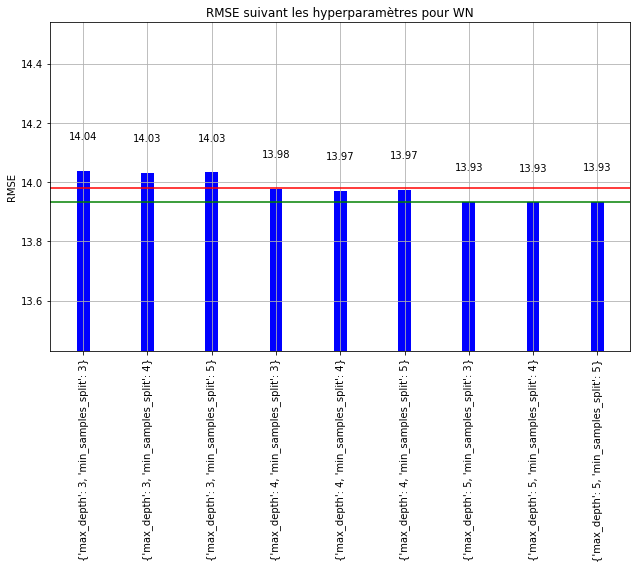

RMSE :  13.6256 pour {'eps': 0.1, 'n_alphas': 2}
RMSE :  13.6256 pour {'eps': 0.1, 'n_alphas': 3}
RMSE :  13.6256 pour {'eps': 0.1, 'n_alphas': 4}
RMSE :  13.6256 pour {'eps': 0.1, 'n_alphas': 5}
RMSE :  13.4609 pour {'eps': 0.01, 'n_alphas': 2}
RMSE :  13.4609 pour {'eps': 0.01, 'n_alphas': 3}
RMSE :  13.4609 pour {'eps': 0.01, 'n_alphas': 4}
RMSE :  13.4609 pour {'eps': 0.01, 'n_alphas': 5}
RMSE :  13.4452 pour {'eps': 0.001, 'n_alphas': 2}
RMSE :  13.4452 pour {'eps': 0.001, 'n_alphas': 3}
RMSE :  13.4452 pour {'eps': 0.001, 'n_alphas': 4}
RMSE :  13.4452 pour {'eps': 0.001, 'n_alphas': 5}

Meilleur score :  13.4452 pour {'eps': 0.001, 'n_alphas': 2}


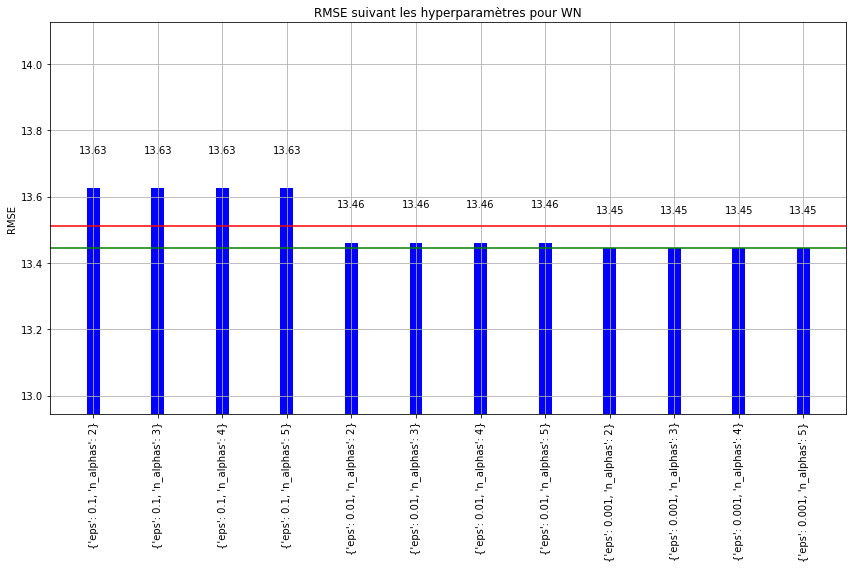

Empty DataFrame
Columns: [Classifier, Id, RMSE, R2]
Index: []
        RMSE                Hyperparametres
0  13.625602    {'eps': 0.1, 'n_alphas': 2}
0  13.625602    {'eps': 0.1, 'n_alphas': 3}
0  13.625602    {'eps': 0.1, 'n_alphas': 4}
0  13.625602    {'eps': 0.1, 'n_alphas': 5}
0  13.460852   {'eps': 0.01, 'n_alphas': 2}
0  13.460852   {'eps': 0.01, 'n_alphas': 3}
0  13.460852   {'eps': 0.01, 'n_alphas': 4}
0  13.460852   {'eps': 0.01, 'n_alphas': 5}
0  13.445203  {'eps': 0.001, 'n_alphas': 2}
0  13.445203  {'eps': 0.001, 'n_alphas': 3}
0  13.445203  {'eps': 0.001, 'n_alphas': 4}
0  13.445203  {'eps': 0.001, 'n_alphas': 5}


In [11]:
 # Récupération des dataset
data = pd.read_csv(_FICHIERDATA, error_bad_lines=False, low_memory=False)
del data['Unnamed: 0']

# Premier algorithme
log, log_cv = lancer_algorithme(data)

# Affichages
print(log)
print(log_cv)

# On enlève un regresseur hors-norme
log = log[log['Classifier'] != 'LinearRegression']

# Affichages
affichage_resultats(log.pivot(index='Id', columns='Classifier', values='RMSE'))
affichage_resultats(log.pivot(index='Classifier', columns='Id', values='RMSE'))

# Conclusion

L'algorithme RandomForestRegressor est celui qui obtient les meilleurs résultats, mais il est aussi le plus lent et le plus volumineux. Il n'est pas donc retenu, étant donné que le gain par rapport avec les autres ne justifie pas cette hausse de consommation.

Dans un second temps, l'optimisation des divers algorithmes a permis d'améliorer de très peu leurs précisions.